## Introduction
You are in the interactive version of the work "TDoA-based Target Pursuit: A Model Predictive Control Approach".
It's the final project of the course Dynamical Systems and Optimization [Técnico Lisboa].
The author is Anton Tolstonogov.

**Working in Google Colab (web)**:
* To execute all cells in Google Colab, select **Runtime** -> **Run All** (or press the combination Ctrl + F9) in the top toolbar.

**Working in VSCode (standalone)**:
* To execute all cells just press the **Run All** button in the top toolbar.

**Notes**:
* By default the optimization problem is only calculated once during the session. If you want it to be recalculated each time it is run, set **RecalculateSkip**=False.
* It takes about 1-2 minutes to complete the entire calculation.
* All animations are precompiled and will not be changed if the code is changed. To force compilation it's necessary to delete the video, but be careful, creating the video is a long process (up to 1 hour for some of them).
* There are two cases are considering in the work. To switch between them just change variable **CaseNumber** (1 or 2).

In [1]:
# Jupyter auxiliary functions
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Additional magic to make only once initialized variables
try:
    if StaticDataLoaded:
        pass
except:
    MPCisCalculated = False
StaticDataLoaded = True

In [2]:
# Jupyter auxiliary functions 2 (loading modules)
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # We need to additionaly install casadi package for the Github Colab
    %pip install casadi
    !git clone https://github.com/bioniwulf/DSO-FinalProject.git --depth=1 ./project
    %cd ./project

# Auxiliary Python libraries
import time
from pathlib import Path

# Special python library for displaying images
from IPython.display import Image

# Different modules for loading video depending on the environment
if not IN_COLAB:
    from IPython.display import Video
else:
    import moviepy.editor

# Numpy library for matrix representation
import numpy as np

# Casadi library for solving Non-linear optimization problem
from casadi import *

# MatplotLib library for plotting figures
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation

# Local modules for calculation within this project
from TargetModel import TargetModel
from TDoACalculation import TDoACalculation
from TDoAPlot import TDoAPlot
from TrackerModel import TrackerModel

# The set of utility functions within this project
import utility as ut

def run_video(video_path:str):
    """
    Run embed video because the behavior in VSCode and Google colab is differ.

    Args:
    ----
        video_path (str): the path to the video.

    Returns:
    -------
        function: run video
    """
    if IN_COLAB:
        return moviepy.editor.ipython_display(str(video_path))
    else:
        return Video(url=video_path)

In [3]:
# Skip MPC recalculation (if it already was calculated at least once)
RecalculateSkip=True

In [4]:
# NOTE All simulation variables are loaded preliminary

# The considering case
# The case 1: Circular pursuit the target by trackers
# The case 2: Plain pursuit the target by trackers without rotation
CaseNumber = 1

# ---Define the discretization constants
DeltaT = 0.1 # Sampling time, s
PredictionN = 20 # Prediction horizon (prediction steps)

# Maximum simulation time, s
SimulationTime = 85.0

# ---Define the Control limitation
# Control constraints for trackers
VLimitTracker     = [0.0, 4.0]      # Limitation for vehicle linear velocity, m/s
OmegaLimitTracker = [-np.pi / 3, np.pi / 3] # Limitation for vehicle angular velocity, rad/s

# Control constraints for the imaginary tracker
VLimitImTracker     = [0.0, 1.0]      # Limitation for vehicle linear velocity, m/s
OmegaLimitImTracker = [-np.pi / 3, np.pi / 3] # Limitation for vehicle angular velocity, rad/s

# Define Weight for running cost
Q = np.diag([15, 15, 0.1]) # Weight for the state vector, Matrix 3x3
R = np.diag([0.5, 0.02])   # Weight for the control vector, Matrix 2x2
D = np.diag([0.5, 0.5])    # Weight for the control difference, Matrix 2x2

# The initial state of the tracker 1, [m, m, rad]
Tracker1StateInitial = np.array([[15.0], [-5.0], [np.pi / 2]])
# The initial state of the tracker 2, [m, m, rad]
Tracker2StateInitial = np.array([[20.0], [-5.0], [np.pi / 2]])

# Minimal Distance between vehicles, m/s
AvoidanceRadius = 1.0

# Velocity of the target, m/s
TargetVelocity = 0.5

# Vehicle rotation radius, m
RotationRadius = 5.0

# AngularRotation, rad/s
RotationVelocity = np.pi / 4

# TDoA-based Target Pursuit: A Model Predictive Control Approach

Globally, there is considerable interest in the development of tools and methodologies for ocean exploration, with a particular emphasis on the pressing and challenging issue of monitoring marine life and studying how the concentration and movement patterns of certain species relate to the state of the environment (e.g. temperature, salinity, pH, and type and concentration of nutrients).
This activity is of paramount importance to "translate marine animal tracking data into conservation policy and management".
However, achieving this objective is fraught with challenges, primarily due to the vastness of the ocean and the limited operational time and robustness of single marine robots.
Consequently, current trends are driving the development of multiple marine vehicles that collaborate.
These vehicles are capable of determining, based on real-time data gathered during observation and monitoring missions, the most effective course of action to take (adaptive sampling).
This approach aims to circumvent the need for exhaustive surveys and/or blind sampling of the environment, thereby optimizing the allocation of resources and ensuring the most efficient use of time.
Furthermore, cooperative systems are required to collectively localize and track/pursue multiple underwater species simultaneously.
This can be achieved using acoustic tags and receivers placed on-board autonomous surface vehicles (ASVs) or even underwater robots (AUVs or gliders).

The specific nature of the problem under consideration (i.e. tracking of underwater species) poses challenges that do not occur in the realm of marine robotics and underwater submersibles.
The reason for this is that the acoustic tags that underwater species can carry must necessarily be small and consume very little power.
Consequently, the majority of tags are simple emitters, thus rendering the task of computing their position with acoustic receivers by resorting to range-based trilateration techniques virtually impossible.
Thus, there is an imperative for alternative methodologies that may employ time-difference of arrival (TDoA) strategies utilizing multiple receivers on a single or networked tracker vehicle operating in cooperation.

This, however, leads to the challenging problem of how to plan the motion of the trackers such that their maneuvers provide a sufficiently rich information set to estimate the target position based on TDoA-based measurements.

The present paper is motivated by the considerations outlined above.
It provides the first insight into the question of how to plan optimal motions for a set of two trackers to maximize the information set for localization of a tracker based on TDoA-based measurements.
This is achieved in the simplest synthetic case, when the position and linear velocity of the target at the given time are known.

# Problem Formulation
## System Model

Consider two trackers charged with the task of following the moving target.
In what follows, $\{\mathcal{I}\} = \{x_\mathcal{I}, y_\mathcal{I} \}$ denotes an inertial frame, $\{\mathcal{B}\}^{[i]} = \{ x^{[i]}_\mathcal{B}, y^{[i]}_\mathcal{B}\}$ denotes a body frame attached to the tracker $i; i \in \mathcal{S}=\{1,2\}$ and $\{\mathcal{H}\} = \{x_\mathcal{H}, y_\mathcal{H} \}$ denotes a hyperbolic frame attached to the focus of the hyperbola, which is the result of the solution of a TDoA measurement by receivers on the trackers.

### Tracker Kinematic Model
The planar motion of tracker $i$ can be described by the simplified kinematic model:
\begin{equation}
    \begin{bmatrix}
        \dot{\mathbf{p}}^{[i]}\\
	\dot{\psi}^{[i]}
    \end{bmatrix}
    =
    \begin{bmatrix}
        \dot{x}^{[i]} \\
        \dot{y}^{[i]} \\
        \dot{\psi}^{[i]}
    \end{bmatrix}
    =
    \begin{bmatrix}
        v^{[i]}\cos{\psi^{[i]}} \\
        v^{[i]}\sin{\psi^{[i]}} \\
        r^{[i]}
    \end{bmatrix}
\end{equation}
where
* $\mathbf{p}^{[i]}=[x^{[i]}, y^{[i]}]^\intercal \in \mathbb{R}^2$ is the position of tracker $i$ in $\{\mathcal{I}\}$,
* $v^{[i]}$ is its total linear speed,
* $\psi^{[i]}$ is the heading angle,
* $r^{[i]}$ is the heading angle rate.


The trackers' model can now be rewritten in state space representation as follows
\begin{equation}
    \dot{\mathbf{x}}^{[i]} = \mathbf{g}(\mathbf{x}^{[i]}, \mathbf{u}^{[i]})
\end{equation}
where $\mathbf{x}^{[i]}=[x^{[i]}, y^{[i]}, \psi^{[i]}]^\intercal \in \mathbb{R}^3$ is the state vector and $\mathbf{u}^{[i]}=[v^{[i]},r^{[i]}]^\intercal \in \mathbb{R}^2$ is the input vector.

The $\mathbf{g}(\mathbf{x}^{[i]}, \mathbf{u}^{[i]})$ is nonlinear function that is given by:
$$
    \mathbf{g}(\mathbf{x}^{[i]}, \mathbf{u}^{[i]}) =
    \begin{bmatrix}
        v^{[i]}\cos{\psi^{[i]}}\\
        v^{[i]}\sin{\psi^{[i]}}\\
        r^{[i]} \\
    \end{bmatrix}
$$

Later, for the purpose of system design, will be discretized in time, yielding
\begin{equation}
    \mathbf{x}_{k+1}^{[i]} = \mathbf{g_d}(\mathbf{x}_{k}^{[i]}, \mathbf{u}_{k}^{[i]})
\end{equation}
where $k \in \mathbb{N}$ indexes discrete time instants and $\mathbf{g_d}(\cdot)$ is the nonlinear discrete function.

The simplest Euler discretization method was used.
In this case, the state $\mathbf{x}_{k+1}^{[i]}$ at the next step of discretization denoted as follows:

\begin{equation*}
    \mathbf{x}_{k+1}^{[i]}
    =
    \begin{bmatrix}
        x^{[i]}_{k+1} \\
        y^{[i]}_{k+1} \\
        \psi^{[i]}_{k+1} \\
    \end{bmatrix}
    =
    \begin{bmatrix}
        x^{[i]}_k \\
        y^{[i]}_k \\
        \psi^{[i]}_k \\
    \end{bmatrix}
    +
    \Delta T
    \begin{bmatrix}
        v^{[i]}_k\cos{\psi^{[i]}_k}\\
        v^{[i]}_k\sin{\psi^{[i]}_k}\\
        r^{[i]}_k \\
    \end{bmatrix}
\end{equation*}



### Target Model
To ensure smooth and continuous motion, the target trajectory is modelled using a B-spline, which provides a flexible and efficient representation of curves.

Suppose the target moves along the predefined trajectory $\mathbf{q}(u) = [q_x(u), q_y(u)]^\intercal \in \mathbb{R}^2$ described by a B-spline, where $u \in [0,1]$ is a parameter of the spline.

The B-spline curve $\mathbf{q}(u)$ of degree $p$ is expressed as a linear combination of basis functions:
$$
\mathbf{q}(u) = \sum_{i=0}^{n-1}N_{i, p}(u)\mathbf{C}^{i}
$$
where $\mathbf{C}^{i} = [C_x^{i}, C_y^{i}]^\intercal \in \mathbb{R}^2$ are the control points of the B-spline ($i \in [1, \ldots, n_c]$), the weights for corresponding basis functions.
$N_{i,p}$ are the B-spline basis functions of degree $p$, defined in the knot vector $u = [u_0, \ldots, u_m]$, with $u_i \leq u_{i+1}$, where $m=n_c+p$.

The basis functions $N_{i,p}$ are defined recursively using Cox–de Boor recursion formula \cite{prautzsch2002bezier}.
For degree p = 0, the basis functions are piecewise constant:
$$
N_{i,0}
=
\begin{cases}
    1, \text{ if } u_i \leq u \leq u_{i+1}, \text{ for } i = n-1 \\
    0, \text{otherwise}
\end{cases}
$$
For degree $p > 0$, the recursive definition is given by:
$$
N_{i,p} (u) = \frac{u-u_i}{u_{i+p} - u_i}N_{i,p-1} (u) + \frac{u_{i+p+1}-u}{u_{i+p+1} - u_{i+1}}N_{i+1,p-1} (u)
$$

The clamped version of the B-spline trajectory is adopted in this work.
It means that the curve passes through the first and last control points, which is utilized to satisfy boundary conditions.
This is achieved by repeating both the first and last knot $p + 1$ times, ensuring that the first basis function evaluates to 1 at time point $p = 0$ while the other basis functions are evaluated to $0$, and the same applies reversely at the end time point.

In this work we require constant speed trajectory control, so it is necessary to move the target along the B-spline curve at a constant speed during the simulation process, and the spline curve adjustment quantity $\Delta u$ needs to be updated at each interpolation cycle.
For this reason, the discrete version of B-spline trajectory is the following:
$$
    \mathbf{q}(u_{k+1}) = \sum_{i=0}^{n-1}N_{i, p}(u_{k} + \Delta u_k)\mathbf{C}^{i}
$$
where $\Delta u$ is as follows
$$
    \Delta u_k = \frac{v_t \Delta T}{|\frac{\delta \mathbf{q}(u)}{\delta u}|_{u=u_k}}
$$
where $v_t$ is a constant velocity of the target and $\Delta T$ is the interpolation period.

(6, 2)


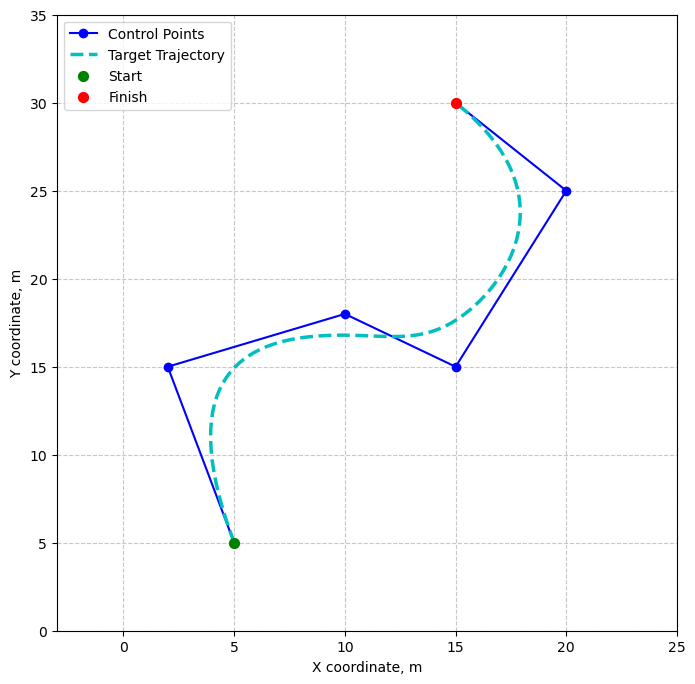

In [5]:
# Control points for the target trajectory 
ControlPoints = np.array([[  5.0,  5.0],
                          [  2.0,  15.],
                          [ 10.0,  18.],
                          [ 15.,   15.],
                          [ 20.,   25.],
                          [ 15.,   30.]
                          ])
print(ControlPoints.shape)

# Create target model as B-spline of degree 3 based on defined control points
target_model = TargetModel(ControlPoints, TargetVelocity)

# Get full target trajectory to show how it looks like
target_tragectory = target_model.get_trajectory()

# Display trajectory of the target on the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_xlabel('X coordinate, m')
ax.set_ylabel('Y coordinate, m')

# Adaptively set the border for the plot
ax.set_xlim(min(ControlPoints[:,0]) - 5, max(ControlPoints[:, 0]) + 5)
ax.set_ylim(min(ControlPoints[:,1]) - 5, max(ControlPoints[:, 1]) + 5)

ax.grid(True, linestyle="--", alpha=0.7)

ax.plot(ControlPoints[:, 0], ControlPoints[:, 1], '-o', label='Control Points', color='b', zorder=2)
ax.plot(target_tragectory[:, 0], target_tragectory[:, 1], '--', linewidth=2.5, label='Target Trajectory', color='c', zorder=2)
ax.scatter(target_tragectory[0, 0], target_tragectory[0, 1], marker='o', s=50, label='Start', color='g', zorder=3)
ax.scatter(target_tragectory[-1, 0], target_tragectory[-1, 1], marker='o', s=50, label='Finish', color='r', zorder=3)
ax.legend(loc='upper left')
plt.show()

## Objective
The main objective is to find smooth linear speed $v^{[i]}(t)$ and heading rate $r^{[i]}(t)$ references for an autopilot of both trackers to fulfil the following tasks:
* **Target localize**: Ensure that the measurements provide "sufficiently rich range information" to estimate the target states based on TDoA-based measurements.
* **Target pursuit**: Ensure that the trackers are in the vicinity of the target.

# Preliminary Analysis
The aim of this section is to present the TDoA-based measurement model and to select an appropriate geometric trajectory pattern based on the chosen metrics in order to maximize the localization capability of the target.

## TDoA-based Measurement Model
The position of the target with two receivers belongs to the locus of points of the following hyperbola (see Figure \ref{fig:hyperbolic_solution}):
\begin{equation}
    \frac{(q_{x,k}^{\mathcal{H}})^2}{a^2} - \frac{(q_{y,k}^{\mathcal{H}})^2}{b^2} = 1 \\
\end{equation}
and hyperbolic semi-axes $a$ and $b$ are determent as follows:
\begin{align}
    a^2 &= (\frac{1}{2}DD_{1,2T})^2 \\
    b^2 &= (\frac{1}{2}||\mathbf{p}_k^{[1]} - \mathbf{p}_k^{[2]}||)^2 - a^2
\end{align}
where:
* *$\mathbf{q}_k^{\mathcal{H}} = [q_{x,k}^{\mathcal{H}}, q_{y,k}^{\mathcal{H}}]^\intercal$ is the possible position of the target at discrete time $k$ in the hyperbolic reference frame $\{\mathcal{H}\}$.
* *$||\mathbf{p}_k^{[1]} - \mathbf{p}_k^{[2]}||$ is the distance between two trackers,
* *$DD_k^{1,2T}$ is a time difference of signal arrival between two trackers at discrete time $k$.

To facilitate the simulation, the parametric representation of the hyperbolic solution was used:
\begin{align*}
    q_{x,k}^{\mathcal{H}} &= \pm a \cosh{t} \\
    q_{y,k}^{\mathcal{H}} &= b \sinh{t}
\end{align*}
where $t \in \mathbb{R}$ is a parameter of the hyperbola.
The sign of $a$ depends on the sign of $DD_k^{1,2T}$.

The representation of the solution in the hyperbolic frame $\mathcal{H}$, $\mathbf{q}_k^{\mathcal{H}}$, and in the inertial frame $\mathcal{I}$, $\mathbf{q}_k^{\mathcal{I}}$, are connected by transformation matrix $T_k$:
\begin{equation*}
    \begin{bmatrix}
        q_{x,k}^{\mathcal{H}} \\
        q_{y,k}^{\mathcal{H}} \\
        1
    \end{bmatrix}
    =
    T_k
    \begin{bmatrix}
        q_{x,k}^{\mathcal{I}} \\
        q_{y,k}^{\mathcal{I}} \\
        1
    \end{bmatrix}
    =
    \begin{bmatrix}
        \cos{\theta_k} & -\sin{\theta_k} & C_k^x \\
        \sin{\theta_k} & \cos{\theta_k} & C_k^y \\
        0 & 0 & 1 \\
    \end{bmatrix}
    \begin{bmatrix}
        q_{x,k}^{\mathcal{I}} \\
        q_{y,k}^{\mathcal{I}} \\
        1
    \end{bmatrix}
\end{equation*}
where $C_k = [C_k^x, C_k^y]^\intercal$ is the center between trackers (the focus of the hyperbola) at the time $k$ expressed in the $\mathcal{I}$:
\begin{equation*}
    \begin{bmatrix}
        C_k^x\\
        C_k^y
    \end{bmatrix}
    =
    \begin{bmatrix}
        \frac{1}{2}(x^{[1]}_k + x^{[2]}_k)\\
        \frac{1}{2}(y^{[1]}_k + y^{[2]}_k)\\
    \end{bmatrix}
\end{equation*}
where $\mathbf{p}^{[1]} = [x^{[1]}_k, y^{[1]}_k]$ and $\mathbf{p}^{[2]} = [x^{[2]}_k, y^{[2]}_k]$ are the position of tracker 1 and tracker 2 at the time $k$, respectively.

The rotation angle $\theta_k$ is defined as:
\begin{equation*}
    \theta_k = \arctan{(y^{[1]}_k - y^{[2]}_k, x^{[1]}_k - x^{[2]}_k)}
\end{equation*}

### Example of TDoA Hyperbolic solution

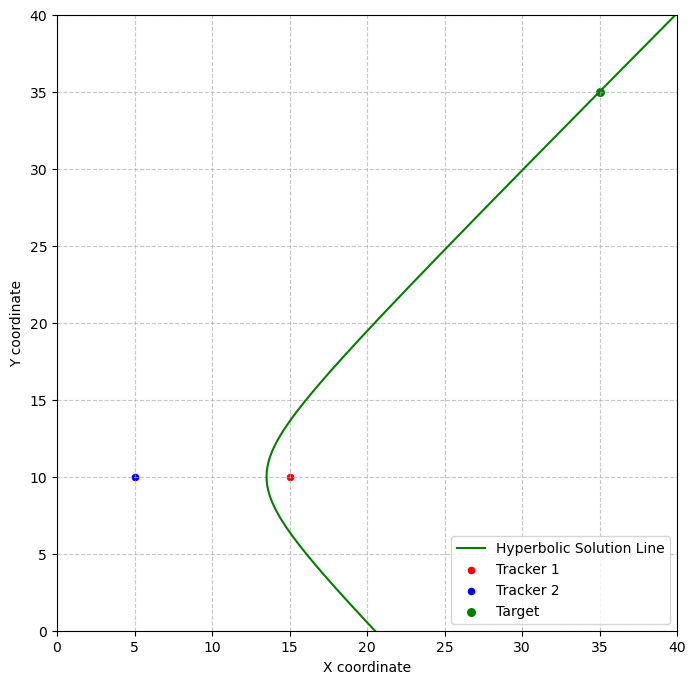

In [6]:
# Create instance of TDoACalculation class
hyperbolic_parameter_max = 4.0
discretization_steps = 1000
tdoa_calculation = TDoACalculation(hyperbolic_parameter_max, discretization_steps)

# Target Position, [m, m]
TargetPosition = np.array([35.0, 35.0])

# First Tracker Position, [m, m]
Tracker1_Position = np.array([15, 10.0])

# Second Tracker Position, [m, m]
Tracker2_Position = np.array([5, 10.0])

# Calculate hyperbolic solution
(x_inertial, y_inertial) = tdoa_calculation.find_hyperbolic_solution(TargetPosition,
                                                                     Tracker1_Position, Tracker2_Position)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_xlim( 0., 40.)
ax.set_ylim( 0., 40.)
ax.grid(True, linestyle="--", alpha=0.7)

solution_line = ax.plot(x_inertial, y_inertial, label="Hyperbolic Solution Line", color="green")[0]

plt_tracker_1 = ax.scatter(Tracker1_Position[0], Tracker1_Position[1], color="red", label=f"Tracker 1", s=20)
plt_tracker_2 = ax.scatter(Tracker2_Position[0], Tracker2_Position[1], color="blue", label=f"Tracker 2", s=20)
plt_target    = ax.scatter(TargetPosition[0], TargetPosition[1], color="green", label=f"Target", s=30)

ax.legend(loc='lower right')
plt.show()

## Trajectory Pattern Comparison Metric
In the work, the time-cumulative histogram approach was used as a comparison metric for different movement patterns of the trackers.
The main idea is to divide the 2D field of inertial frame $\mathcal{I}$ into histogram bins of a given size and discretize the hyperbolic solution to a set of points.
In the event of the point of solution fits within a histogram bin, the counter for that bin is incremented.
This process is then repeated for each discrete moment at which the trackers are moved along the trajectory patterns.

## Trajectory patterns
Experience from other approaches to this problem (range-based localization and bearing-based localization) suggests that there must be some kind of circular orbit around the target.
In the work, several circular orbit trajectory patterns are proposed and compared based on the proposed comparison metric.

In all the scenarios described below, the trackers moved within the circular area bounded by a radius of $R=20$ m around the point $[0,0]$, the position of the tracker $\mathbf{p}^{[t]}$ is fixed: $\mathbf{p}^{[t]} = [50, 50]$ m.
The simulation time and the time discrete period for these simulations are the same and equal to $200$ s and $1$ s respectively.

### Rotation Around the Tracker 1
In this pattern, tracker 1 is fixed and tracker 2 orbits around tracker 1 with radius $R$ and angular velocity $\omega$ as follows:
\begin{align*}
    \mathbf{p}^{[1]}(t) &= [x_\text{fix}^{[1]}, y_\text{fix}^{[2]}] \\
    \mathbf{p}^{[2]}(t) &= [x_\text{fix}^{[1]} + R\cos{wt}, y_\text{fix}^{[1]} + R\sin{wt}]^\intercal
\end{align*}

#### Animated version

In [7]:
AnimationSteps = 100

# Target Position, [m, m]
TargetPosition = np.array([50.0, 50.0])

# Rotation Radius
TrackerRadius = 20

# First Tracker
Tracker1PosShift = [0.0, 0.0]
Tracker1Velocity = [0.0, 0.0]
Tracker1AngleVelocity = 0.1
Tracker1AnglePhase = 0

# Second Tracker
Tracker2PosShift = [0.0, 0.0]
Tracker2Velocity = [0.0, 0.0]
Tracker2AngleVelocity = 0.1
Tracker2AnglePhase = 0

# Instance for plotting the histograms
hist_range = (-100, 100)
tdoa_plot = TDoAPlot(hist_range, hist_range)
tdoa_plot.close_plot()

def trajectory_step(t: float):
    # Trajectory. First tracker in center
    tracker_position_1 = np.array([(Tracker1PosShift[0] + Tracker1Velocity[0] * t),
                                   (Tracker1PosShift[1] + Tracker1Velocity[1] * t)])
    tracker_position_2 = np.array([(Tracker2PosShift[0] + Tracker2Velocity[0] * t + TrackerRadius * np.cos(Tracker1AngleVelocity * t)),
                                   (Tracker2PosShift[1] + Tracker2Velocity[1] * t + TrackerRadius * np.sin(Tracker1AngleVelocity * t))])
    return (TargetPosition, tracker_position_1, tracker_position_2)

video_path = tdoa_plot.make_animation(file_path=Path('fig/pattern 1.mp4'),
                                      animation_step_fn=trajectory_step,
                                      steps=AnimationSteps, time_interval=150)
run_video(video_path)

#### Static version

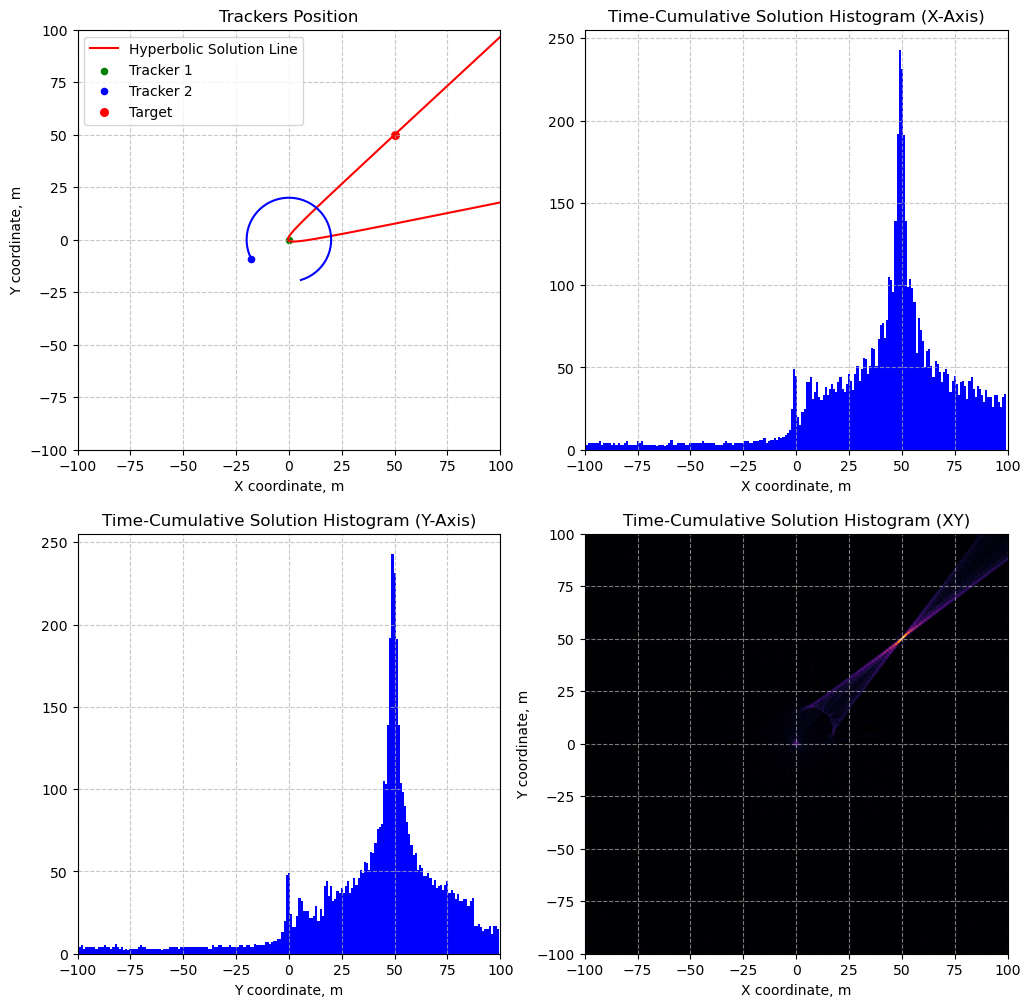

In [8]:
tdoa_plot = TDoAPlot(hist_range, hist_range)
tdoa_plot.make_static(animation_step_fn=trajectory_step, steps = AnimationSteps)

### Opposite Rotation
In this pattern, tracker 1 orbits around the center $\mathbf{c}=[c_x, c_y]^\intercal$ with radius $R_1$ and angular velocity $\omega_1>0$ and tracker 2 orbits around the same center with radius $R_2$ and angular velocity $\omega_2<0$ in opposite direction as follows:
\begin{align*}
    \mathbf{p}^{[1]}(t) &= [c_x + R_1\cos{w_1t}, c_y + R_1\sin{w_1t}]^\intercal\\
    \mathbf{p}^{[2]}(t) &= [c_x + R_2\cos{w_2t}, c_y + R_2\sin{w_2t}]^\intercal
\end{align*}
The radius $R_1, R_2$ and angular velocities $\omega_1$, $\omega_2$ are related as
\begin{equation*}
    R_1 w_1 = R_2 w_2
\end{equation*}
to make linear velocities of trackers the same.

#### Animated Version

In [9]:
AnimationSteps = 100

# Target Position, [m, m]
TargetPosition = np.array([50.0, 50.0])

# Rotation Radius
TrackerRadius = 20

# First Tracker
Tracker1PosShift = [0.0, 0.0]
Tracker1Velocity = [0.0, 0.0]
Tracker1AngleVelocity = 0.1
Tracker1AnglePhase = 0

# Second Tracker
Tracker2PosShift = [0.0, 0.0]
Tracker2Velocity = [0.0, 0.0]
Tracker2AngleVelocity = 0.1
Tracker2AnglePhase = 0

hist_range = (-100, 100)
tdoa_plot = TDoAPlot(hist_range, hist_range, False, 20)
tdoa_plot.close_plot()

def trajectory_step(t: float):
    tracker_position_1 = np.array([(Tracker1PosShift[0] + Tracker1Velocity[0] * t + TrackerRadius / 2 * np.cos(2 * Tracker2AngleVelocity * t)),
                                   (Tracker1PosShift[1] + Tracker1Velocity[1] * t + TrackerRadius / 2 * np.sin(2 * Tracker2AngleVelocity * t))])
    tracker_position_2 = np.array([(Tracker2PosShift[0] + Tracker2Velocity[0] * t + TrackerRadius * np.cos(-Tracker2AngleVelocity * t)),
                                   (Tracker2PosShift[1] + Tracker2Velocity[1] * t + TrackerRadius * np.sin(-Tracker2AngleVelocity * t))])
    return (TargetPosition, tracker_position_1, tracker_position_2)

video_path = tdoa_plot.make_animation(file_path=Path('fig/pattern 2.mp4'),
                                      animation_step_fn=trajectory_step,
                                      steps=AnimationSteps, time_interval=150)
run_video(video_path)

#### Static Version

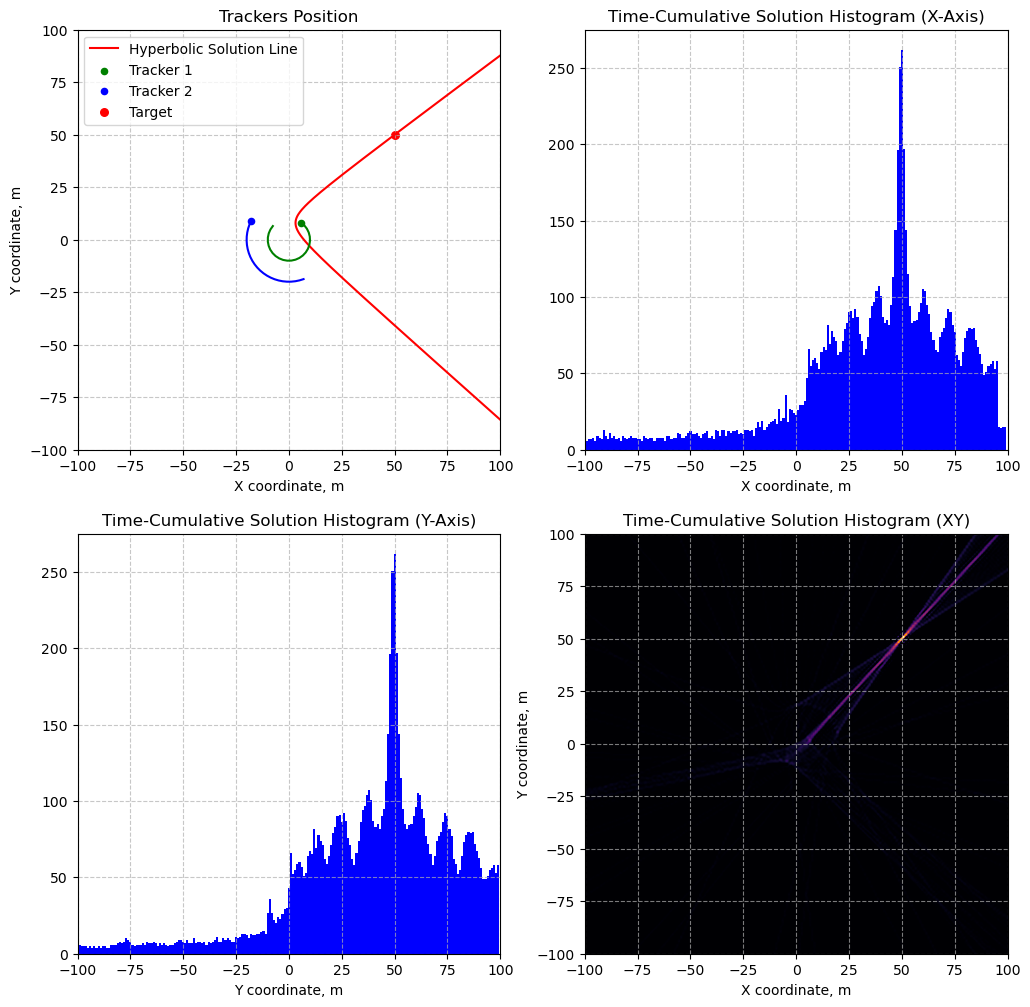

In [10]:
tdoa_plot = TDoAPlot(hist_range, hist_range, False, 25)
tdoa_plot.make_static(animation_step_fn=trajectory_step, steps = AnimationSteps)

### Co-rotation with the $\pi$ Phase Shift
In this pattern, tracker 1 and tracker 2 orbit around the center $\mathbf{c}=[c_x, c_y]^\intercal$ with radius $R$ and angular velocity $\omega$, but the tracker 2 moves with the $\pi$ phase shift as follows:
\begin{align*}
    \mathbf{p}^{[1]}(t) &= [c_x + R\cos{wt}, c_y + R\sin{wt}]^\intercal\\
    \mathbf{p}^{[2]}(t) &= [c_x + R\cos{(wt + \pi)}, c_y + R\sin{(wt + \pi)}]^\intercal
\end{align*}

#### Animated Version

In [11]:
import numpy as np
%matplotlib inline

from TDoAPlot import TDoAPlot

AnimationSteps = 100

# Target Position, [m, m]
TargetPosition = np.array([50.0, 50.0])

# Rotation Radius
TrackerRadius = 20

# First Tracker
Tracker1PosShift = [0.0, 0.0]
Tracker1Velocity = [0.0, 0.0]
Tracker1AngleVelocity = 0.1
Tracker1AnglePhase = 0

# Second Tracker
Tracker2PosShift = [0.0, 0.0]
Tracker2Velocity = [0.0, 0.0]
Tracker2AngleVelocity = 0.1
Tracker2AnglePhase = np.pi

hist_range = (-100, 100)
tdoa_plot = TDoAPlot(hist_range, hist_range, False, 25)
tdoa_plot.close_plot()

def trajectory_step(t: float):
    tracker_position_1 = np.array([Tracker1PosShift[0] + Tracker1Velocity[0] * t + TrackerRadius * np.sin(Tracker1AngleVelocity * t + Tracker1AnglePhase),
                                   Tracker1PosShift[1] + Tracker1Velocity[1] * t + TrackerRadius * np.cos(Tracker1AngleVelocity * t + Tracker1AnglePhase)])
    tracker_position_2 = np.array([Tracker2PosShift[0] + Tracker2Velocity[0] * t + TrackerRadius * np.sin(Tracker2AngleVelocity * t + Tracker2AnglePhase),
                                   Tracker2PosShift[1] + Tracker2Velocity[1] * t + TrackerRadius * np.cos(Tracker2AngleVelocity * t + Tracker2AnglePhase)])
    return (TargetPosition, tracker_position_1, tracker_position_2)

video_path = tdoa_plot.make_animation(file_path=Path('fig/pattern 3.mp4'),
                                      animation_step_fn=trajectory_step,
                                      steps=AnimationSteps, time_interval=150)
run_video(video_path)

#### Static Version

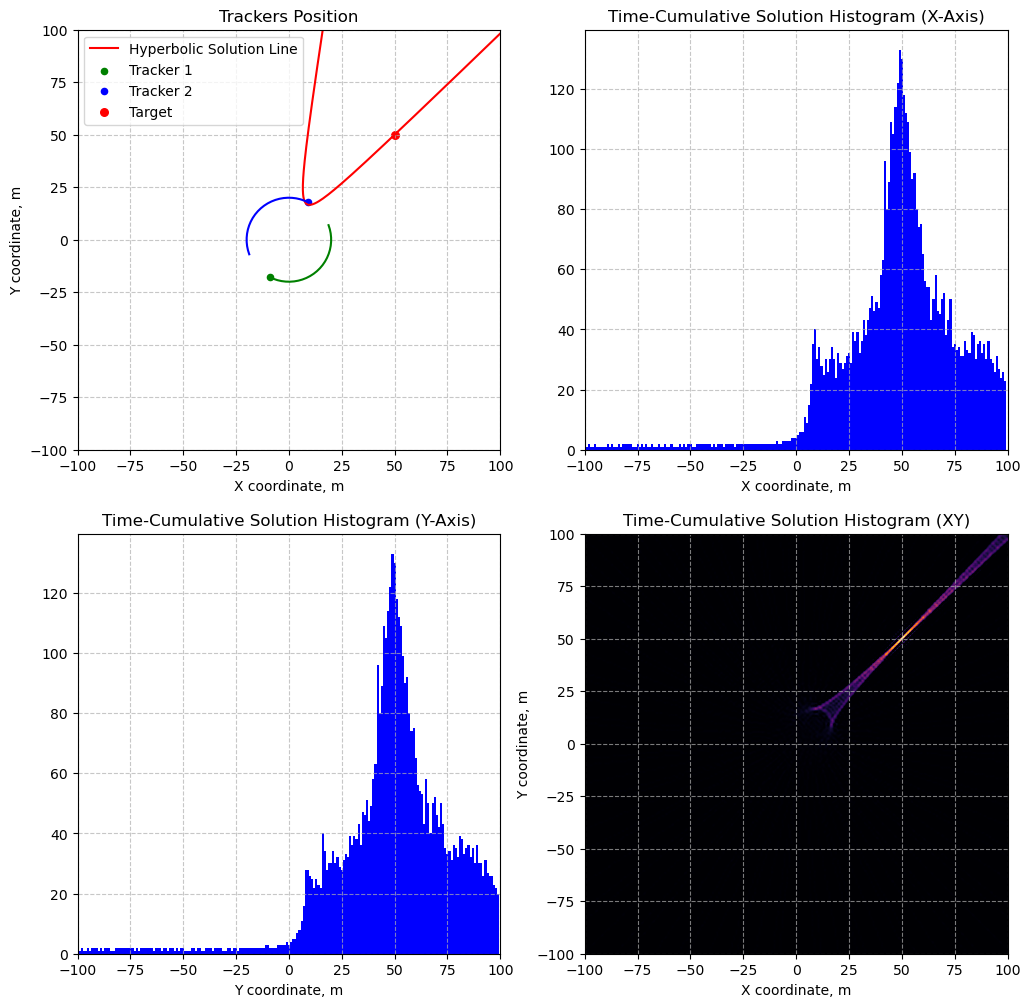

In [12]:
tdoa_plot = TDoAPlot(hist_range, hist_range, False, 25)
tdoa_plot.make_static(animation_step_fn=trajectory_step, steps = AnimationSteps)

### Co-rotation with the $\pi/2$ Phase Shift
In this pattern, tracker 1 and tracker 2 orbit around the center $\mathbf{c}=[c_x, c_y]^\intercal$ with radius $R$ and angular velocity $\omega$, but the tracker 2 moves with the $\pi/2$ phase shift as follows:
\begin{align*}
    \mathbf{p}^{[1]}(t) &= [c_x + R\cos{wt}, c_y + R\sin{wt}]^\intercal\\
    \mathbf{p}^{[2]}(t) &= [c_x + R\cos{(wt + \pi/2)}, c_y + R\sin{(wt + \pi/2)}]^\intercal
\end{align*}

#### Animated Version

In [13]:
AnimationSteps = 100

# Target Position, [m, m]
TargetPosition = np.array([50.0, 50.0])

# Rotation Radius
TrackerRadius = 20

# First Tracker
Tracker1PosShift = [0.0, 0.0]
Tracker1Velocity = [0.0, 0.0]
Tracker1AngleVelocity = 0.1
Tracker1AnglePhase = 0

# Second Tracker
Tracker2PosShift = [0.0, 0.0]
Tracker2Velocity = [0.0, 0.0]
Tracker2AngleVelocity = 0.1
Tracker2AnglePhase = np.pi / 2

# Instance for plotting the histograms
hist_range = (-100, 100)
tdoa_plot = TDoAPlot(hist_range, hist_range, False, 25)
tdoa_plot.close_plot()

def trajectory_step(t: float):
    tracker_position_1 = np.array([Tracker1PosShift[0] + Tracker1Velocity[0] * t + TrackerRadius * np.sin(Tracker1AngleVelocity * t + Tracker1AnglePhase),
                                   Tracker1PosShift[1] + Tracker1Velocity[1] * t + TrackerRadius * np.cos(Tracker1AngleVelocity * t + Tracker1AnglePhase)])
    tracker_position_2 = np.array([Tracker2PosShift[0] + Tracker2Velocity[0] * t + TrackerRadius * np.sin(Tracker2AngleVelocity * t + Tracker2AnglePhase),
                                   Tracker2PosShift[1] + Tracker2Velocity[1] * t + TrackerRadius * np.cos(Tracker2AngleVelocity * t + Tracker2AnglePhase)])
    return (TargetPosition, tracker_position_1, tracker_position_2)

video_path = tdoa_plot.make_animation(file_path=Path('fig/pattern 4.mp4'),
                                      animation_step_fn=trajectory_step,
                                      steps=AnimationSteps, time_interval=150)
run_video(video_path)

#### Static Version

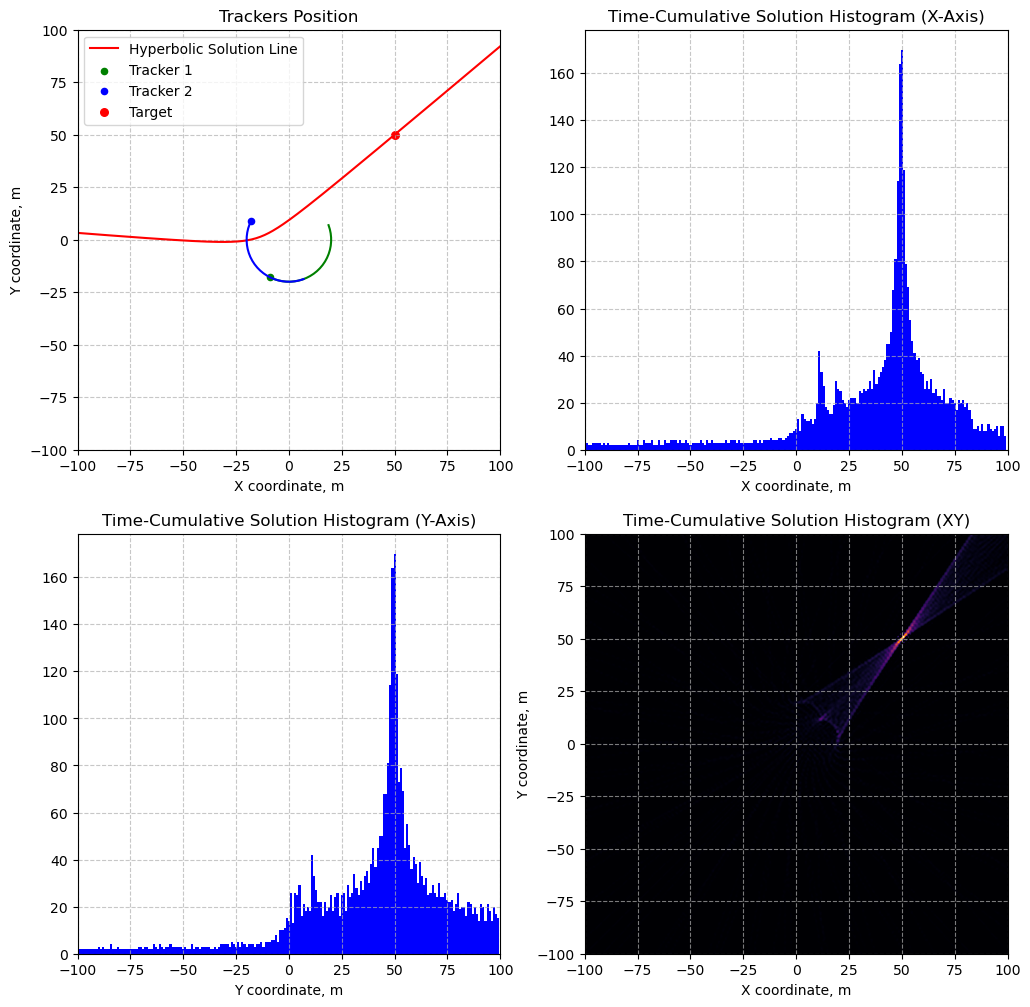

In [14]:
tdoa_plot = TDoAPlot(hist_range, hist_range, False, 25)
tdoa_plot.make_static(animation_step_fn=trajectory_step, steps = AnimationSteps)

## Pattern Analysis Result
It has been shown that the first and last trajectory patterns give optimal results in terms of signal-to-noise ratio on one-dimensional histograms.
Nevertheless, the first pattern does not align with the proposed scenario due to the unequal energy expenditure between the vehicles.
Consequently, the last trajectory pattern (co-rotation with $\pi/2$ phase shift) was utilized to formulate the MPC problem in the next section.

This result is consistent with the best mutual position for two trackers and one target for the range-based SLAP problem that maximizes the range information about the target.

# MPC framework for Target Pursuit
## Preliminary Analysis and Problem Decomposition

Due to the chosen trajectory pattern of the tracker movement, it's reasonable to decompose the MPC tracking problem into two sub-problems:
* pursuit the target by the rotation center around which the trackers are orbiting,
* trackers circulating along the circumference trajectory around the moving rotation center.


In this approach we treat the center of rotation as a tracker with the same kinematic model as real ones to provide the smooth pursuit trajectory, but with a lower maximum linear velocity to allow the trackers to circulate around the rotation center without loosing of synchronization.

The principal scheme of the controller is illustrated in Figure below.

It can be seen from the scheme that the predicted states of MPC controller for the rotation center are used to generate target circular trajectories for both trackers.

The notation is used in the scheme and detailed descriptions are given in the following sections.


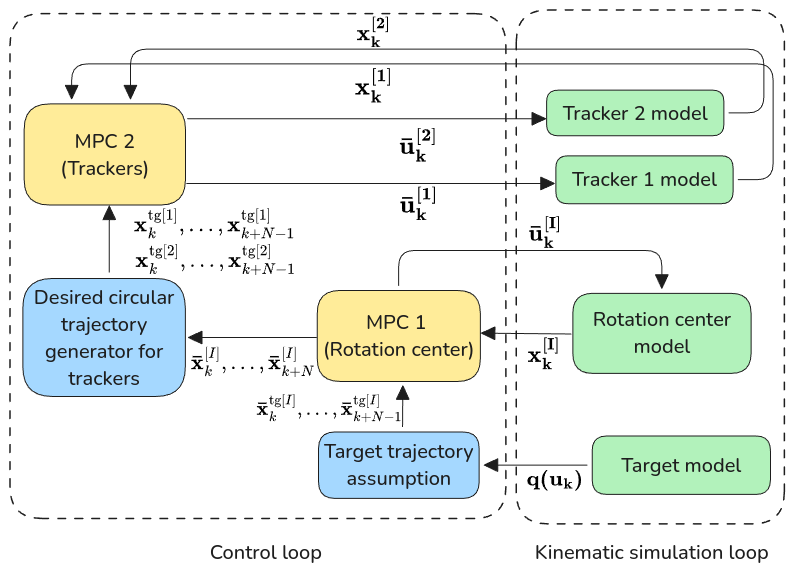

In [15]:
Image("fig/MPC decomposition scheme.png")

## The MPC Problem for the Rotation Center

Let $\mathbf{x}^{[I]}_k$ be the state of the rotation point at discrete time $k$.
The initial position of the rotation point at time $k=0$ is defined as the center between two trackers with the zero heading angle as follows:
\begin{equation}
    \left.\mathbf{x}^{[I]}\right|_{k=0} =
    \begin{bmatrix}
        \frac{1}{2}(x^{[1]}_{k=0} + x^{[2]}_{k=0}) \\
        \frac{1}{2}(y^{[1]}_{k=0} + y^{[2]}_{k=0}) \\
        0
    \end{bmatrix}
\end{equation}

Assume that at each time $k$ the position $\mathbf{q}(u_k)=[q^x(u_k), q^y(u_k)]^\intercal$, heading $\psi^{[t]}_k$, and the constant linear velocity $v_t$ of the target are known.
Given this information, the linear assumption about the trajectory of the tracker within the prediction horizon of the MPC controller can be made.
In this case, the assumed position of the target can be found recursively as:
\begin{align*}
    \bar{\mathbf{q}}_{n+1}
    &=
    \begin{bmatrix}
        q_x(u_{k+1}) \\
        q_y(u_{k+1})
    \end{bmatrix}
    =
    \Delta Tv_t
    \begin{bmatrix}
        \bar{q}_x(u_n)\cos{\psi^{[t]}_n} \\
        \bar{q}_y(u_n)\sin{\psi^{[t]}_n}
    \end{bmatrix} \\
    \bar{\mathbf{q}}_{n=0} &=
    \begin{bmatrix}
        q_x(u_k) \\
        q_y(u_k)
    \end{bmatrix}
\end{align*}
for $n \in \{k,\ldots, k+N-1\}$.

The proposed cost to pursue the target over its assumed trajectory is as follows:
\begin{equation*}
    J_\text{track} = \sum_{n=k}^{k+N-1} (\mathbf{p}^{[I]}_n - \bar{\mathbf{q}}_n)Q(\mathbf{p}^{[I]}_n - \bar{\mathbf{q}}_n)^\intercal
\end{equation*}
where $Q$ is a diagonal non-negative weight matrix.

To maintain the velocity of the rotation center along the prediction horizon the velocity related cost is introduced:
\begin{equation*}
    J_\text{velocity} = \sum_{n=k}^{k+N-1} (\mathbf{u}^{[I]}_n - \mathbf{u}^{[t]})R(\mathbf{u}^{[I]}_n - \mathbf{u}^{[t]})^\intercal
\end{equation*}
where $\mathbf{u}^{[t]} = [v_t, 0]^\intercal$ is a velocity vector of the target.

With the above ingredients, the problem of computing rotation center inputs over a given time-horizon with the purpose of pursuit the target can be cast in the form of the following optimal control problem:

\textbf{Definition 1.} The optimal control problem for the rotation center, denoted $\mathcal{OCP}1 (\mathbf{x}^{[I]}_k, \mathbf{u}^{[I]}_k, \mathbf{q}(u_k), \psi^{[t]}_k, v_t)$, is stated as follows
\begin{equation}
    \min_{\bar{\mathbf{u}}^{[I]}, \bar{\mathbf{x}}^{[I]}} J_\text{track} + J_\text{velocity}
\end{equation}
subject to
\begin{align}
    \bar{\mathbf{x}}_{n+1}^{[I]} &= \mathbf{g_d} (\bar{\mathbf{x}}_{n}^{[I]}, \bar{\mathbf{u}}_{n}^{[I]}) \\ 
    \bar{\mathbf{x}}_{k}^{[I]} &= \mathbf{x}_k^{[I]} \\
    \bar{\mathbf{x}}_{n}^{[I]} &\in \mathcal{X}^{[I]} \\
    \bar{\mathbf{u}}_{n}^{[I]} &\in \mathcal{V}^{[I]}
\end{align}
for $n \in \{k,\ldots, k+N-1\}$.

In the constraint equations, the variables with bar denote predicted variables, to distinguish them from the actual variables,which are without bars.
These equations are associated with the trackers’ kinematics model and the trackers’ state and input constraints.

In the MPC scheme, the optimal control problem $\mathcal{OCP}1(·)$ is repeatedly solved at every discrete sampling instant $k$.

The $\bar{\mathbf{u}}^{[I]} = [\bar{\mathbf{u}}^{[I]}_{k}, \ldots, \bar{\mathbf{u}}^{[I]}_{k + N - 1}]$ and $\bar{\mathbf{x}}^{[I]} = [\bar{\mathbf{x}}^{[I]}_{k}, \ldots, \bar{\mathbf{x}}^{[I]}_{k + N}]$ are the solutions of the optimal control problem for control input and the state vector respectively over the prediction horizon.
The first control input $\bar{\mathbf{u}}^{[I]}_{k}$ is used to control the rotation center and the set of predicted states $\bar{\mathbf{x}}^{[I]}$ is used as the source trajectory to build target circular trajectories for tracker 1 and tracker 2.

At each time instant $k$, the target states $[\mathbf{x}^{\text{tg}[1]}_{k}, \ldots \mathbf{x}^{\text{tg}[1]}_{k+N-1}]$, $[\mathbf{x}^{\text{tg}[2]}_{k}, \ldots \mathbf{x}^{\text{tg}[2]}_{k+N-1}]$ for the tracker 1 and the tracker 2 respectively are built up based on the set of rotation center predicted states $\bar{\mathbf{x}}^{[I]}$ as follows:
\begin{equation}
    \mathbf{x}^{\text{tg}[i]}_{n} =
    \begin{bmatrix}
        x^{\text{tg}[i]}_{n} \\
        y^{\text{tg}[i]}_{n} \\
        \psi^{\text{tg}[i]}_{n}
    \end{bmatrix}
    =
    \begin{bmatrix}
        \bar{x}^{[I]}_{n} + R\cos{wt_n + \varphi_i} \\
        \bar{y}^{[I]}_{n} + R\sin{wt_n + \varphi_i} \\
        \psi^{\text{tg}[i]}_{n}
    \end{bmatrix}
\end{equation}
where $\psi^{\text{tg}[i]}_{n}$ is the angle of the tangent vector to the circumference at the point $[\bar{x}^{[I]}_{n} + R\cos{wt_n}, \bar{y}^{[I]}_{n} + R\sin{wt_n}]^\intercal$ for $n \in \{k,\ldots, k+N-1\}$ and for $i \in (1,2)$.
The phase shift is denoted as $\varphi_i$, for the tracker 1 $\varphi_1=0$ and as $\varphi_2 = \frac{\pi}{2}$ for the tracker 2.

## The MPC Problem for the Trackers
The formulation of the MPC problem the trackers is similar to the previous one.

The cost of orbiting the rotation center is as follows:
\begin{equation*}
    J_\text{track} = \sum_{i=1}^{2} \sum_{n=k}^{k+N-1} (\mathbf{x}^{[i]}_n - \mathbf{x}^{\text{tg}[i]}_n)Q(\mathbf{x}^{[i]}_n - \mathbf{x}^{\text{tg}[i]}_n)^\intercal
\end{equation*}
where $Q$ is a diagonal non-negative weight matrix for states.

To maintain the desired velocity of the trackers along the prediction horizon, the velocity-related cost is:
\begin{equation*}
    J_\text{velocity} = \sum_{i=1}^{2} \sum_{n=k}^{k+N-1} (\mathbf{u}^{[i]}_n - \mathbf{u}^{\text{tg}[i]})R(\mathbf{u}^{[i]}_n - \mathbf{u}^{\text{tg}[i]})^\intercal
\end{equation*}
where $\mathbf{u}^{[i]} = [v^{[i]}_n, w^{[i]}_n]^\intercal$ is desired linear and angular vector of the tracker $i$ on the trajectory.
The linear velocity $v_i$ is depended on circular radius $R$ as angular velocity $w$ as $v^{[i]}_n = R w^{[i]}_n$.
The angular rotation $w^{[i]}_n$ remains constant and equals to $w$.

In addition, we introduce the cost function to penalise significant differences between neighbouring control actions in the prediction horizon as follows:
\begin{equation*}
    J_\text{smooth} = \sum_{i=1}^{2} \sum_{n=k+1}^{k+N-1} (\mathbf{u}^{[i]}_n - \mathbf{u}^{[i]}_{n-1})D(\mathbf{u}^{[i]}_n - \mathbf{u}^{[i]}_{n-1})^\intercal
\end{equation*}

With the above ingredients, the problem of computing trackers inputs over a given time-horizon with the purpose of orbiting the moving rotation center can be cast in the form of the following optimal control problem:

\textbf{Definition 2.} The optimal control problem for the trackers, denoted $\mathcal{OCP}2 (\mathbf{x}^{[i]}_k, \mathbf{u}^{[i]}_k, \mathbf{x}^{\text{tg}[i]}_{k})$, is stated as follows
\begin{equation}
    \min_{\bar{\mathbf{u}}^{[i]}, \bar{\mathbf{x}}^{[i]}} J_\text{track} + J_\text{velocity} + J_\text{smooth}
\end{equation}
subject to
\begin{align}
    \bar{\mathbf{x}}_{n+1}^{[i]} &= \mathbf{g_d} (\bar{\mathbf{x}}_{n}^{[i]}, \bar{\mathbf{u}}_{n}^{[I]}) \\
    ||\bar{\mathbf{p}}_{n}^{[1]}& - \bar{\mathbf{p}}_{n}^{[2]}|| > R_a \\
    \bar{\mathbf{x}}_{k}^{[i]} &= \mathbf{x}^{[i]} \\
    \bar{\mathbf{x}}_{n}^{[i]} &\in \mathcal{X}^{[i]} \\
    \bar{\mathbf{u}}_{n}^{[i]} &\in \mathcal{V}^{[i]}
\end{align}
for $n \in \{k,\ldots, k+N-1\}$ and $i \in \{1,2\}$.
The definition of $\mathcal{OCP}2$ is almost the same as the definition of $\mathcal{OCP}1$ except for the constraint \ref{eq:ocp2_2}.
This constraint ensures collision avoidance between the trackers, where $||\bar{\mathbf{p}}_{n}^{[1]} - \bar{\mathbf{p}}_{n}^{[2]}||$ is a distance between predicted states of the trackers and $R_a$ is the collision avoidance minimal radius.

# Simulation Results

### Rotation Center Model (Casadi Simulation Setup)

In [16]:
%%skip_if (RecalculateSkip and MPCisCalculated)
# Create MPC instance for the imaginary point between trackers
trackerI = TrackerModel(label="trackerI", prediction_horizon=PredictionN)

# Objective function for the imaginary point
im_objective = 0
im_objective = im_objective + trackerI.create_objective(Q, R, D)

# Symbolic constraints for the imaginary point
im_constraints = []
im_constraints = im_constraints + trackerI.create_constraints(DeltaT)

# Convert Python list to CasADi Matrix (vertical concatination)
im_constraints = vertcat(*im_constraints)

st_size   = trackerI.state_vector.size()[0]
ctrl_size = trackerI.control_vector.size()[0]

im_input = np.array([])
im_input = vertcat(im_input, reshape(trackerI.get_state_prediction(), st_size * (PredictionN + 1), 1))
im_input = vertcat(im_input, reshape(trackerI.control_prediction, PredictionN * ctrl_size, 1))

im_init = np.array([])
im_init = vertcat(im_init, trackerI.state_init)
im_init = vertcat(im_init, trackerI.state_reference)

# Configure the NLP solver (general view for all step within the prediction horizon)
im_nlp = {}
# objective function
im_nlp['f'] = im_objective
# Control inputs for NLP as column vector
im_nlp['x'] = im_input
# Initial state and reference states
im_nlp['p'] = im_init
# NLP constraints
im_nlp['g'] = im_constraints

# Define the configuration options for the solver
im_opts = {}
im_opts["print_time"] = 0
im_opts["verbose"] = False
im_opts["ipopt.max_iter"] = 100
im_opts["ipopt.print_level"] = 0
im_opts["ipopt.acceptable_tol"] = 1e-8
im_opts["ipopt.acceptable_obj_change_tol"] = 1e-6

# Initialize the global constraints (see constraints)
# To get equality condition we need to set upper and lower bound parameters as zeros
im_args = {}

# Equality constraints by kinematic model
(trackerI_lbg, trackerI_ubg) = trackerI.get_global_limits()
im_args["lbg"] = trackerI_lbg
im_args["ubg"] = trackerI_ubg

# Limits for vehicles state
(trackerI_lbx, trackerI_ubx) = trackerI.get_state_limits(VLimitImTracker, OmegaLimitImTracker)
im_args["lbx"] = trackerI_lbx
im_args["ubx"] = trackerI_ubx

# Initialize the NLP solver
im_solver = nlpsol('im_solver', 'ipopt', im_nlp, im_opts)

### Trackers' Model (Casadi Simulation Setup)

In [17]:
%%skip_if (RecalculateSkip and MPCisCalculated)
# Create MPC instance for the tracker 1
tracker1 = TrackerModel(label="tracker1", prediction_horizon=PredictionN)

# Create MPC instance for the tracker 2
tracker2 = TrackerModel(label="tracker2", prediction_horizon=PredictionN)

# Create objective function for both vehicles with the same weight
objective = 0
objective = objective + tracker1.create_objective(Q, R, D)
objective = objective + tracker2.create_objective(Q, R, D)

# Define equality constraints as a python list for both vehicles and imaginary point
constraints = []
constraints = constraints + tracker1.create_constraints(DeltaT)
constraints = constraints + tracker2.create_constraints(DeltaT)

# Add constraints on the distance between two vehicles
for step in range(0, PredictionN + 1):
    tracker1_state = tracker1.get_state_prediction(step)
    tracker2_state = tracker2.get_state_prediction(step)
    constraints.append(AvoidanceRadius - np.sqrt((tracker1_state[0] - tracker2_state[0])**2 + (tracker1_state[1] - tracker2_state[1])**2))

# Convert Python list to CasADi Matrix (vertical concatination)
constraints = vertcat(*constraints)

# Reshape control variables (because we need to configure for NLP only one dimensional vector)
# But now we need to prepare the much larger vector of predictions of all states and controls within the receiving horizon
input = np.array([])
input = vertcat(input, reshape(tracker1.get_state_prediction(), st_size * (PredictionN + 1), 1))
input = vertcat(input, reshape(tracker1.control_prediction, PredictionN * ctrl_size, 1))

input = vertcat(input, reshape(tracker2.get_state_prediction(), st_size * (PredictionN + 1), 1))
input = vertcat(input, reshape(tracker2.control_prediction, PredictionN * ctrl_size, 1))

init = np.array([])
init = vertcat(init, tracker1.state_init)
init = vertcat(init, tracker1.state_reference)
init = vertcat(init, tracker2.state_init)
init = vertcat(init, tracker2.state_reference)

# Configure the NLP solver (general view for all step within the prediction horizon)
nlp = {}
# objective function
nlp['f'] = objective
# Control inputs for NLP as column vector
nlp['x'] = input
# Initial state and reference states
nlp['p'] = init
# NLP constraints
nlp['g'] = constraints

# Define the configuration options for the solver
opts = {}
opts["print_time"] = 0
opts["verbose"] = False
opts["ipopt.max_iter"] = 100
opts["ipopt.print_level"] = 0
opts["ipopt.acceptable_tol"] = 1e-8
opts["ipopt.acceptable_obj_change_tol"] = 1e-6

# Initialize the global constraints (see constraints)
# To get equality condition we need to set upper and lower bound parameters as zeros
args = {}
# Equality constraints by kinematic model
(tracker1_lbg, tracker1_ubg) = tracker1.get_global_limits()
(tracker2_lbg, tracker2_ubg) = tracker2.get_global_limits()

args["lbg"] = np.vstack((tracker1_lbg, tracker2_lbg)) 
args["ubg"] = np.vstack((tracker1_ubg, tracker2_ubg))

# Inequality constraints by collision avoidance between vehicles
obstacle_lower_bounds = np.zeros((PredictionN + 1, 1))
obstacle_lower_bounds[:] = -inf
args["lbg"] = np.vstack((args["lbg"], obstacle_lower_bounds)) 

obstacle_upper_bounds = np.zeros((PredictionN + 1, 1))
obstacle_upper_bounds[:] = 0
args["ubg"] = np.vstack((args["ubg"], obstacle_upper_bounds)) 

# Limits for vehicles state
(tracker1_lbx, tracker1_ubx) = tracker1.get_state_limits(VLimitTracker, OmegaLimitTracker)
(tracker2_lbx, tracker2_ubx) = tracker2.get_state_limits(VLimitTracker, OmegaLimitTracker)
args["lbx"] = np.vstack((tracker1_lbx, tracker2_lbx))
args["ubx"] = np.vstack((tracker1_ubx, tracker2_ubx))

# Initialize the solver
solver = nlpsol('solver', 'ipopt', nlp, opts)

### Simulation Loop

In [18]:
%%skip_if (RecalculateSkip and MPCisCalculated)
# We don't have any prediction, so zeros are our best guess
tracker1_control_guess = np.zeros((PredictionN, ctrl_size))
# The state on the first point will be not far of the Tracker1StateInitial
tracker1_state_guess = repmat(Tracker1StateInitial, 1, PredictionN + 1)

# We don't have any prediction, so zeros are our best guess
tracker2_control_guess = np.zeros((PredictionN, ctrl_size))
# The state on the first point will be not far of the Tracker1StateInitial
tracker2_state_guess = repmat(Tracker2StateInitial, 1, PredictionN + 1)

# Find the middle point between states
TrackerI_state_initial = ut.get_middle_point(Tracker1StateInitial, Tracker2StateInitial)
TrackerI_state_initial = np.vstack((TrackerI_state_initial, [np.pi / 2]))

# We don't have any prediction, so zeros are our best guess
trackerI_control_guess = np.zeros((PredictionN, ctrl_size))
# The state on the first point will be not far of the Tracker1StateInitial
trackerI_state_guess = repmat(TrackerI_state_initial, 1, PredictionN + 1)

# Storage for target states
storage_target_states = []

# Storage of target predictions
storage_target_predictions = []

# Target trajectories for the trackers
storage_tracker1_trajectory = []
storage_tracker2_trajectory = []

# Current state of the robot. At the beginning it coincides with the x_start
tracker1_state_current = Tracker1StateInitial
tracker2_state_current = Tracker2StateInitial
trackerI_state_current = TrackerI_state_initial

# Start timer to check performance
time_start = time.process_time()

# Target trajectory parameter
sim_time  = 0

# Storage for the time series, s
storage_timeline = []

# Main Loop of the motion control
while sim_time < SimulationTime:
    #----- Update target position
    # Get target state and target velocity at the current moment
    (target_state, target_velocity) = target_model.get_tracker_telemetry()

    (state_trajectory, target_proposed_trajectory) = ut.get_proposed_state_sequence(target_state, target_velocity, PredictionN, DeltaT)
    storage_target_predictions.append(state_trajectory)

    #----- Prepare initial vector for tracker I
    # Upload new initial state (new each step) and the target state (for each point within the prediction horizon)
    # First part is current state
    trackerI_init = []
    trackerI_init.append(trackerI_state_current.flatten())
    trackerI_init = trackerI_init + target_proposed_trajectory
    # Reshape the initial vector to standard Casadi representation
    trackerI_init = np.concatenate(trackerI_init, axis=0)
    trackerI_init = trackerI_init.reshape(-1, 1)
    im_args["p"] = trackerI_init

    # Set initial guess for NLP
    im_initial_guess = np.array([])
    # Initial guess for the tracker I
    im_initial_guess = vertcat(im_initial_guess, reshape(trackerI_state_guess, st_size * (PredictionN + 1), 1))
    im_initial_guess = vertcat(im_initial_guess, reshape(trackerI_control_guess.T, ctrl_size * PredictionN, 1))
    im_args["x0"] = im_initial_guess

    #----- Solve the OCP only for the imaginary point
    im_solution = im_solver(x0=im_args["x0"], p=im_args["p"],
                            lbx=im_args["lbx"], ubx=im_args["ubx"],
                            lbg=im_args["lbg"], ubg=im_args["ubg"]
                            )

    trackerI_solution = im_solution['x']

    # Extract state predictions with reshaping to initial representation
    trackerI_state_predictions = reshape(trackerI_solution[:st_size * (PredictionN + 1)].T, st_size, PredictionN + 1)
    # Extract control predictions with reshaping to initial representation
    trackerI_control_predictions = reshape(trackerI_solution[st_size * (PredictionN + 1):].T, ctrl_size, PredictionN).T
    # We need only the first control value in the storage
    trackerI_control = trackerI_control_predictions[0, :]

    #----- Prepare initial vector for tracker 1
    # Upload new initial state (new each step) and the target state (for each point within the prediction horizon)
    # First part is current state
    (circular_trajectory, circular_init_vector) = \
        ut.get_circular_trajectory(trackerI_state_predictions, RotationVelocity, 0, sim_time, RotationRadius, DeltaT)
    storage_tracker1_trajectory.append(circular_trajectory)

    tracker1_init = []
    tracker1_init.append(tracker1_state_current.flatten())

    if CaseNumber == 1:
        tracker1_init = tracker1_init + circular_init_vector
    elif CaseNumber == 2:
        tracker1_init = tracker1_init + target_proposed_trajectory

    # Reshape the initial vector to standard representation
    tracker1_init = np.concatenate(tracker1_init, axis=0)
    tracker1_init = tracker1_init.reshape(-1, 1)

    #----- Prepare initial vector for tracker 2
    # Upload new initial state (new each step) and the target state (for each point within the prediction horizon)
    # First part is current state
    (circular_trajectory, circular_init_vector) = \
        ut.get_circular_trajectory(trackerI_state_predictions, RotationVelocity, np.pi / 2, sim_time, RotationRadius, DeltaT)
    storage_tracker2_trajectory.append(circular_trajectory)

    tracker2_init = []
    tracker2_init.append(tracker2_state_current.flatten())

    if CaseNumber == 1:
        tracker2_init = tracker2_init + circular_init_vector
    elif CaseNumber == 2:
        tracker2_init = tracker2_init + target_proposed_trajectory

    # Reshape the initial vector to standard representation
    tracker2_init = np.concatenate(tracker2_init, axis=0)
    tracker2_init = tracker2_init.reshape(-1, 1)

    args["p"] = np.vstack((tracker1_init, tracker2_init))

    #----- Prepare initial guess for tracker 1 and tracker 2
    # Set initial guess for NLP
    initial_guess = np.array([])
    # Initial guess for the tracker 1
    initial_guess = vertcat(initial_guess, reshape(tracker1_state_guess, st_size * (PredictionN + 1), 1))
    initial_guess = vertcat(initial_guess, reshape(tracker1_control_guess.T, ctrl_size * PredictionN, 1))
    # Initial guess for the tracker 2
    initial_guess = vertcat(initial_guess, reshape(tracker2_state_guess, st_size * (PredictionN + 1), 1))
    initial_guess = vertcat(initial_guess, reshape(tracker2_control_guess.T, ctrl_size * PredictionN, 1))

    args["x0"] = initial_guess

    #----- Solve the OCP for both vehicles
    sol = solver(x0=args["x0"], p=args["p"],
                 lbx=args["lbx"], ubx=args["ubx"],
                 lbg=args["lbg"], ubg=args["ubg"]
                 )

    # Divide solution for two parts (for the tracker 1 and tracker 2)
    (tracker1_solution, tracker2_solution) = np.array_split(sol['x'], 2)

    # Reshape obtained control predictions vector to matrix (2xPredictionN)
    # Extract only control predictions
    tracker1_control_predictions = reshape(tracker1_solution[st_size * (PredictionN + 1):].T, ctrl_size, PredictionN).T
    # We need only the first control value in the storage
    tracker1_control = tracker1_control_predictions[0, :]

    # Reshape obtained contol predictions vector to matrix (2xPredictionN)
    # Extract only control predictions
    tracker2_control_predictions = reshape(tracker2_solution[st_size * (PredictionN + 1):].T, ctrl_size, PredictionN).T
    # We need only the first control value in the storage
    tracker2_control = tracker2_control_predictions[0, :]

    # Extract only state predictions
    tracker1_state_predictions = reshape(tracker1_solution[:st_size * (PredictionN + 1)].T, st_size, PredictionN + 1)

    # Extract only state predictions
    tracker2_state_predictions = reshape(tracker2_solution[:st_size * (PredictionN + 1)].T, st_size, PredictionN + 1)

    #----- Storage data for tracker 1
    # Store the state vector on the each step of simulation
    tracker1.storage_state(tracker1_state_current)

    # Store predicted states in the list of 2D Matrix
    tracker1.storage_predictions(tracker1_state_predictions.T)

    # Store only the first control value in the storage
    tracker1.storage_control(tracker1_control)

    #----- Storage data for tracker 2
    # Store the state vector on the each step of simulation
    tracker2.storage_state(tracker2_state_current)

    # Store predicted states in the list of 2D Matrix
    tracker2.storage_predictions(tracker2_state_predictions.T)

    # Store only the first control value in the storage
    tracker2.storage_control(tracker2_control)

    #----- Storage data for tracker I
    # Store the state vector on the each step of simulation
    trackerI.storage_state(trackerI_state_current)

    # Store predicted states in the list of 2D Matrix
    trackerI.storage_predictions(trackerI_state_predictions.T)

    # Store only the first control value in the storage
    trackerI.storage_control(trackerI_control)

    # Store current target state
    storage_target_states.append(target_state)

    storage_timeline.append(sim_time)

    #----- Shift state of the tracker 1
    # Shift the time and initial position for solver
    # We propagate control actions to obtain the new state of the system at this point
    tracker1_state_current = tracker1_state_current + (DeltaT *  tracker1.kin_function(tracker1_state_current, tracker1_control.T))
    tracker1_state_current = np.array(tracker1_state_current)
    
    tracker2_state_current = tracker2_state_current + (DeltaT *  tracker2.kin_function(tracker2_state_current, tracker2_control.T))
    tracker2_state_current = np.array(tracker2_state_current)
    
    trackerI_state_current = trackerI_state_current + (DeltaT *  trackerI.kin_function(trackerI_state_current, trackerI_control.T))
    trackerI_state_current = np.array(trackerI_state_current)

    #----- Shift state of the target
    target_model.update_tracker_position(DeltaT)
    sim_time = sim_time + DeltaT

    #----- Shift state and control guess of the tracker 1
    # We the control action predictions and state predictions as the best guess for the next control
    # Just trim the first row, because we already used it and append zero row at the end
    tracker1_control_guess = np.delete(tracker1_control_predictions, 0, axis=0)
    tracker1_control_guess = np.vstack((tracker1_control_guess, tracker1_control_predictions[-1, :]))

    tracker1_state_guess = np.delete(tracker1_state_predictions, 0, axis=1)
    tracker1_state_guess = np.hstack((tracker1_state_guess, tracker1_state_predictions[:, -1]))
    
    tracker2_control_guess = np.delete(tracker2_control_predictions, 0, axis=0)
    tracker2_control_guess = np.vstack((tracker2_control_guess, tracker2_control_predictions[-1, :]))

    tracker2_state_guess = np.delete(tracker2_state_predictions, 0, axis=1)
    tracker2_state_guess = np.hstack((tracker2_state_guess, tracker2_state_predictions[:, -1]))

    trackerI_control_guess = np.delete(trackerI_control_predictions, 0, axis=0)
    trackerI_control_guess = np.vstack((trackerI_control_guess, trackerI_control_predictions[-1, :]))

    trackerI_state_guess = np.delete(trackerI_state_predictions, 0, axis=1)
    trackerI_state_guess = np.hstack((trackerI_state_guess, trackerI_state_predictions[:, -1]))

sim_steps = len(storage_timeline)
elapsed_time = time.process_time() - time_start
print(f"Overal OCP time for all steps: {elapsed_time} sec. Per simulation step: {elapsed_time / sim_steps}")

# Concatinate all data along the second axis (because state is the column-vector)
storage_target_states = np.concatenate(storage_target_states, axis=1)

storage_tracker1_trajectory = np.stack(storage_tracker1_trajectory, axis=2)
storage_tracker2_trajectory = np.stack(storage_tracker2_trajectory, axis=2)

storage_target_predictions = np.stack(storage_target_predictions, axis=2)

# Change flag that we have calculated MPC instances at least once
MPCisCalculated = True


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Overal OCP time for all steps: 30.128989023 sec. Per simulation step: 0.03540421741833137


## Animation of the Rotation Point Trajectory

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_title('The Rotation Center Trajectory')
ax.set_xlabel('X coordinate, m')
ax.set_ylabel('Y coordinate, m')
ax.set_xlim(  0, 25)
ax.set_ylim(-10, 40)
ax.grid(True, linestyle="--", alpha=0.7)

# Get full target trajectory to show how it looks like
target_tragectory = target_model.get_trajectory()

# Plot the target trajectory
ax.plot(target_tragectory[:, 0], target_tragectory[:, 1], '--',
        label='Target trajectory', color='red', zorder=1)

trackerI_states = trackerI.get_state_storage()
trackerI_predictions = trackerI.get_predictions_storage()

angle = storage_target_states[2, 0]
target_pointer = patches.FancyArrow(storage_target_states[0, 0], storage_target_states[1, 0],
                               0.4 * np.cos(angle), 0.4 * np.sin(angle),
                               color='red', width=0.1, 
                               head_width=1.0, head_length=1.0, 
                               label='label',length_includes_head=True, 
                               overhang=0.3, zorder=10)

angle = trackerI_states[2, 0]
trackerI_pointer = patches.FancyArrow(trackerI_states[0, 0], trackerI_states[1, 0],
                               0.4 * np.cos(angle), 0.4 * np.sin(angle),
                               color='grey', width=0.1, 
                               head_width=1.0, head_length=1.0, 
                               label='label',length_includes_head=True, 
                               overhang=0.3, zorder=10)

trackerI_trajectory = ax.plot(trackerI_states[0, 0], trackerI_states[0, 0], 
                            linestyle="--", linewidth=1.5, color='grey', 
                            label='Rotation center trajectory', zorder=1)[0]

target_prediction = ax.scatter(storage_target_predictions[::3, 0, 0], storage_target_predictions[::3, 1, 0],
                               color='red', marker='o', s=5, label='Target trajectory assumption', zorder=1)

tracker1_target = ax.scatter(storage_tracker1_trajectory[:, 0, 0], storage_tracker1_trajectory[:, 1, 0],
                             color='green', marker='o', s=5, label='Target trajectory for tracker 1', zorder=1)

tracker2_target = ax.scatter(storage_tracker2_trajectory[:, 0, 0], storage_tracker2_trajectory[:, 1, 0],
                             color='blue', marker='o', s=5, label='Target trajectory for tracker 2', zorder=1)

trackerI_predict = ax.scatter(trackerI_predictions[::3, 0, 0], trackerI_predictions[::3, 1, 0],
                              color='grey', marker='*', s=5, label='Rotation center trajectory prediction', zorder=1)
ax.legend(loc='upper left')

def init():
    ax.add_patch(target_pointer)
    ax.add_patch(trackerI_pointer)
    return list()

DesiredSteps = 400
factor = sim_steps / DesiredSteps

def animate(i):
    print(i)
    ff_index = int(factor * i)
    ax.patches.clear()

    angle = storage_target_states[2, ff_index]
    target_pointer = patches.FancyArrow(storage_target_states[0, ff_index], storage_target_states[1, ff_index],
                                        0.4 * np.cos(angle), 0.4 * np.sin(angle),
                                        color='red', width=0.0, 
                                        head_width=1.0, head_length=1.0, 
                                        label='label',length_includes_head=True, 
                                        overhang=0.3, zorder=10)
    ax.add_patch(target_pointer)

    angle = trackerI_states[2, ff_index]
    trackerI_pointer = patches.FancyArrow(trackerI_states[0, ff_index], trackerI_states[1, ff_index],
                                        0.4 * np.cos(angle), 0.4 * np.sin(angle),
                                        color='grey', width=0.0, 
                                        head_width=1.0, head_length=1.0, 
                                        label='label',length_includes_head=True, 
                                        overhang=0.3, zorder=10)
    ax.add_patch(trackerI_pointer)

    trackerI_trajectory.set_data(trackerI_states[0, 0:ff_index], trackerI_states[1, 0:ff_index])

    data = np.hstack((storage_target_predictions[::3, 0, ff_index].reshape(-1, 1),
                      storage_target_predictions[::3, 1, ff_index].reshape(-1, 1)))
    target_prediction.set_offsets(data)

    data = np.hstack((storage_tracker1_trajectory[:, 0, ff_index].reshape(-1, 1),
                      storage_tracker1_trajectory[:, 1, ff_index].reshape(-1, 1)))
    tracker1_target.set_offsets(data)

    data = np.hstack((storage_tracker2_trajectory[:, 0, ff_index].reshape(-1, 1),
                      storage_tracker2_trajectory[:, 1, ff_index].reshape(-1, 1)))
    tracker2_target.set_offsets(data)

    data = np.hstack((trackerI_predictions[::3, 0, ff_index].reshape(-1, 1),
                      trackerI_predictions[::3, 1, ff_index].reshape(-1, 1)))
    trackerI_predict.set_offsets(data)
    return list()

# Close figure to prevent rendering on the screen
plt.close(fig)

# Create GIF Animation or upload animation if it was created before
video_path = Path("fig/rotation center trajectory.mp4")
if not video_path.is_file():    
    ani = animation.FuncAnimation(fig, animate,
                                repeat=False, frames=DesiredSteps, init_func=init,
                                interval=150, blit = False)
    ani.save(video_path, writer="ffmpeg")
run_video(video_path)

## Example of Target Trajectory Generation for Trackers

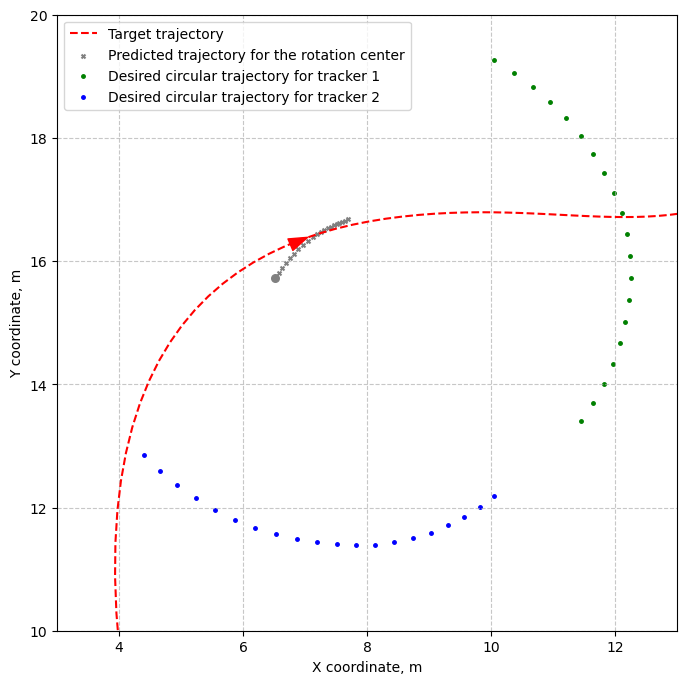

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_xlabel('X coordinate, m')
ax.set_ylabel('Y coordinate, m')
ax.set_xlim(  3, 13)
ax.set_ylim( 10, 20)
ax.grid(True, linestyle="--", alpha=0.7)

# Heading Figure size
target_markersize = 30
tracker_markersize = 30

# Get full target trajectory to show how it looks like
target_tragectory = target_model.get_trajectory()

trackerI_states = trackerI.get_state_storage()
trackerI_predictions = trackerI.get_predictions_storage()

# simulation index
sim_index = 250

# Plot the target trajectory
ax.plot(target_tragectory[:, 0], target_tragectory[:, 1], '--', label='Target trajectory', color='red', zorder=2)

marker_target, scale = ut.gen_arrow_head_marker(storage_target_states[2, sim_index])
pointer_target = ax.scatter(storage_target_states[0, sim_index], storage_target_states[1, sim_index],
                                marker=marker_target, s=(target_markersize * scale)**2, color='red', zorder=3)

trackerI_pointer = ax.scatter(trackerI_states[0, sim_index], trackerI_states[1, sim_index],
                                  marker='o', s=tracker_markersize, color='grey', zorder=3)

trackerI_predict = ax.scatter(trackerI_predictions[:, 0, sim_index], trackerI_predictions[:, 1, sim_index],
                              color='grey', marker='x', s=8, label='Predicted trajectory for the rotation center', zorder=1)

tracker1_target = ax.scatter(storage_tracker1_trajectory[:, 0, sim_index], storage_tracker1_trajectory[:, 1, sim_index],
                                 color='green', marker='.', s=25, label='Desired circular trajectory for tracker 1', zorder=1)
tracker2_target = ax.scatter(storage_tracker2_trajectory[:, 0, sim_index], storage_tracker2_trajectory[:, 1, sim_index],
                             color='blue', marker='.', s=25, label='Desired circular trajectory for tracker 2', zorder=1)
ax.legend(loc='upper left')
plt.show()

## Trackers Trajectory (Animated)

In [21]:
# Get state storages
tracker1_states = tracker1.get_state_storage()
tracker2_states = tracker2.get_state_storage()
trackerI_states = trackerI.get_state_storage()

# Get predictions storages
tracker1_predictions = tracker1.get_predictions_storage()
tracker2_predictions = tracker2.get_predictions_storage()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_title('Trackers Position')
ax.set_xlabel('X coordinate, m')
ax.set_ylabel('Y coordinate, m')
ax.set_xlim(  0, 25)
ax.set_ylim(-10, 40)
ax.grid(True, linestyle="--", alpha=0.7)


# Plot the target trajectory
ax.plot(target_tragectory[:, 0], target_tragectory[:, 1], '--',
        label='Target trajectory', color='red', zorder=1)

angle = storage_target_states[2, 0]
target_pointer = patches.FancyArrow(storage_target_states[0, 0], storage_target_states[1, 0],
                               0.4 * np.cos(angle), 0.4 * np.sin(angle),
                               color='red', width=0.1, 
                               head_width=1.0, head_length=1.0, 
                               label='label',length_includes_head=True, 
                               overhang=0.3, zorder=10)

angle = trackerI_states[2, 0]
trackerI_pointer = patches.FancyArrow(trackerI_states[0, 0], trackerI_states[1, 0],
                               0.4 * np.cos(angle), 0.4 * np.sin(angle),
                               color='grey', width=0.1, 
                               head_width=1.0, head_length=1.0, 
                               label='label',length_includes_head=True, 
                               overhang=0.3, zorder=10)

trackerI_trajectory = ax.plot(trackerI_states[0, 0], trackerI_states[0, 0], 
                            linestyle="--", linewidth=1.5, color='grey', 
                            label='Rotation center trajectory', zorder=1)[0]

angle = tracker1_states[2, 0]
tracker1_pointer = patches.FancyArrow(tracker1_states[0, 0], tracker1_states[1, 0],
                               0.4 * np.cos(angle), 0.4 * np.sin(angle),
                               color='green', width=0.1, 
                               head_width=1.0, head_length=1.0, 
                               label='label',length_includes_head=True, 
                               overhang=0.3, zorder=10)
angle = tracker2_states[2, 0]
tracker2_pointer = patches.FancyArrow(tracker2_states[0, 0], tracker2_states[1, 0],
                               0.4 * np.cos(angle), 0.4 * np.sin(angle),
                               color='blue', width=0.1, 
                               head_width=1.0, head_length=1.0, 
                               label='label',length_includes_head=True, 
                               overhang=0.3, zorder=10)

tracker1_trajectory = ax.plot(tracker1_states[0, 0], tracker1_states[0, 0], 
                            linestyle="-", linewidth=1.5, color='green', 
                            label='Tracker 1 trajectory', zorder=1)[0]
tracker2_trajectory = ax.plot(tracker2_states[0, 0], tracker2_states[0, 0], 
                            linestyle="-", linewidth=1.5, color='blue', 
                            label='Tracker 2 trajectory', zorder=1)[0]

tracker1_predict = ax.scatter(tracker1_predictions[:, 0, 0], tracker1_predictions[:, 1, 0],
                             color='green', marker='x', s=4, zorder=1)
tracker2_predict = ax.scatter(tracker2_predictions[:, 0, 0], tracker2_predictions[:, 1, 0],
                                color='blue', marker='x', s=4, zorder=1)
ax.legend(loc='upper left')

def init():
    ax.add_patch(target_pointer)
    ax.add_patch(trackerI_pointer)
    ax.add_patch(tracker1_pointer)
    ax.add_patch(tracker2_pointer)
    return list()

DesiredSteps = 400
factor = np.floor(sim_steps / DesiredSteps)

def animate(i):
    print(i)
    ff_index = int(factor * i)
    ax.patches.clear()

    angle = storage_target_states[2, ff_index]
    target_pointer = patches.FancyArrow(storage_target_states[0, ff_index], storage_target_states[1, ff_index],
                                        0.4 * np.cos(angle), 0.4 * np.sin(angle),
                                        color='red', width=0.0, 
                                        head_width=1.0, head_length=1.0, 
                                        label='label',length_includes_head=True, 
                                        overhang=0.3, zorder=10)
    ax.add_patch(target_pointer)

    angle = trackerI_states[2, ff_index]
    trackerI_pointer = patches.FancyArrow(trackerI_states[0, ff_index], trackerI_states[1, ff_index],
                                        0.4 * np.cos(angle), 0.4 * np.sin(angle),
                                        color='grey', width=0.0, 
                                        head_width=1.0, head_length=1.0, 
                                        label='label',length_includes_head=True, 
                                        overhang=0.3, zorder=10)
    ax.add_patch(trackerI_pointer)
    
    angle = tracker1_states[2, ff_index]
    tracker1_pointer = patches.FancyArrow(tracker1_states[0, ff_index], tracker1_states[1, ff_index],
                                        0.4 * np.cos(angle), 0.4 * np.sin(angle),
                                        color='green', width=0.0, 
                                        head_width=1.0, head_length=1.0, 
                                        label='label',length_includes_head=True, 
                                        overhang=0.3, zorder=10)
    ax.add_patch(tracker1_pointer)
    
    angle = tracker2_states[2, ff_index]
    tracker2_pointer = patches.FancyArrow(tracker2_states[0, ff_index], tracker2_states[1, ff_index],
                                        0.4 * np.cos(angle), 0.4 * np.sin(angle),
                                        color='blue', width=0.0, 
                                        head_width=1.0, head_length=1.0, 
                                        label='label',length_includes_head=True, 
                                        overhang=0.3, zorder=10)
    ax.add_patch(tracker2_pointer)

    trackerI_trajectory.set_data(trackerI_states[0, 0:ff_index], trackerI_states[1, 0:ff_index])
    tracker1_trajectory.set_data(tracker1_states[0, 0:ff_index], tracker1_states[1, 0:ff_index])
    tracker2_trajectory.set_data(tracker2_states[0, 0:ff_index], tracker2_states[1, 0:ff_index])

    data = np.hstack((storage_tracker1_trajectory[:, 0, ff_index].reshape(-1, 1),
                      storage_tracker1_trajectory[:, 1, ff_index].reshape(-1, 1)))
    tracker1_target.set_offsets(data)

    data = np.hstack((storage_tracker2_trajectory[:, 0, ff_index].reshape(-1, 1),
                      storage_tracker2_trajectory[:, 1, ff_index].reshape(-1, 1)))
    tracker2_target.set_offsets(data)

    data = np.hstack((tracker1_predictions[::2, 0, ff_index].reshape(-1, 1),
                      tracker1_predictions[::2, 1, ff_index].reshape(-1, 1)))
    tracker1_predict.set_offsets(data)

    data = np.hstack((tracker2_predictions[::2, 0, ff_index].reshape(-1, 1),
                      tracker2_predictions[::2, 1, ff_index].reshape(-1, 1)))
    tracker2_predict.set_offsets(data)
    return list()

# Close figure to prevent rendering on the screen
plt.close(fig)

# Create GIF Animation or upload animation if it was created before
video_path = Path(f"fig/tracker trajectories case {CaseNumber}.mp4")
if not video_path.is_file():    
    ani = animation.FuncAnimation(fig, animate,
                                repeat=False, frames=DesiredSteps, init_func=init,
                                interval=150, blit = False)
    ani.save(video_path, writer="ffmpeg")
run_video(video_path)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

## Trackers Trajectory (Static)

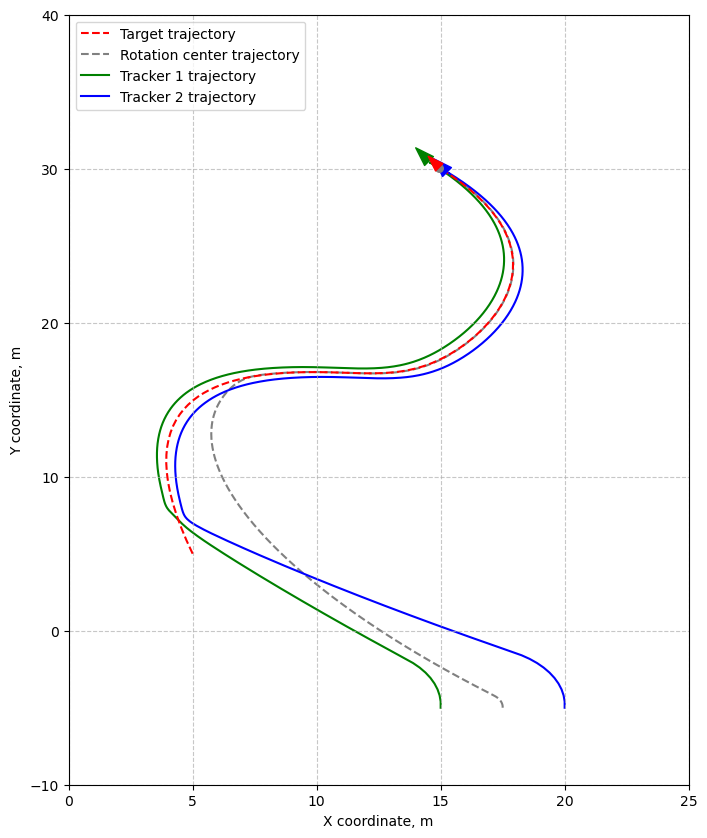

In [22]:
fig, ax_trajectory = plt.subplots(1, 1, figsize=(8, 10))

# Get state storages
tracker1_states = tracker1.get_state_storage()
tracker2_states = tracker2.get_state_storage()

ax_trajectory.set_xlabel('X coordinate, m')
ax_trajectory.set_ylabel('Y coordinate, m')
ax_trajectory.set_xlim(  0, 25)
ax_trajectory.set_ylim(-10, 40)
ax_trajectory.grid(True, linestyle="--", alpha=0.7)

# Heading Figure size
target_markersize = 25
markersize = 30

# Plot the target trajectory
target_tragectory = target_model.get_trajectory()
ax_trajectory.plot(target_tragectory[:, 0], target_tragectory[:, 1], '--', label='Target trajectory', color='red', zorder=2)

marker_tracker, scale = ut.gen_arrow_head_marker(tracker1_states[2, -1])
tracker1_pointer = ax_trajectory.scatter(tracker1_states[0, -1], tracker1_states[1, -1],
                              marker=marker_tracker, s=(tracker_markersize * scale)**2, color='green', zorder=3)

marker_tracker, scale = ut.gen_arrow_head_marker(tracker2_states[2, -1])
tracker2_pointer = ax_trajectory.scatter(tracker2_states[0, -1], tracker2_states[1, -1],
                              marker=marker_tracker, s=(tracker_markersize * scale)**2, color='blue', zorder=3)

trackerI_pointer = ax_trajectory.scatter(trackerI_states[0, -1], trackerI_states[1, -1],
                              marker='o', s=tracker_markersize, color='grey', zorder=3)

trackerI_trajectory = ax_trajectory.plot(trackerI_states[0, :], trackerI_states[1, :], 
                                linestyle="--", linewidth=1.5, color='grey', 
                                label='Rotation center trajectory', zorder=1)[0]

marker_target, scale = ut.gen_arrow_head_marker(storage_target_states[2, -1])
pointer_target = ax_trajectory.scatter(storage_target_states[0, -1], storage_target_states[1, -1],
                            marker=marker_target, s=(target_markersize * scale)**2, color='red', zorder=3)
    
# Plot the trackers trajectory
tracker1_trajectory = ax_trajectory.plot(tracker1_states[0, :], tracker1_states[1, :], 
                                         linestyle="-", linewidth=1.5, color='green', 
                                         label='Tracker 1 trajectory', zorder=1)[0]

tracker2_trajectory = ax_trajectory.plot(tracker2_states[0, :], tracker2_states[1, :], 
                                         linestyle="-", linewidth=1.5, color='blue', 
                                         label='Tracker 2 trajectory', zorder=1)[0]
ax_trajectory.legend(loc='upper left')
plt.show()

## Trackers state

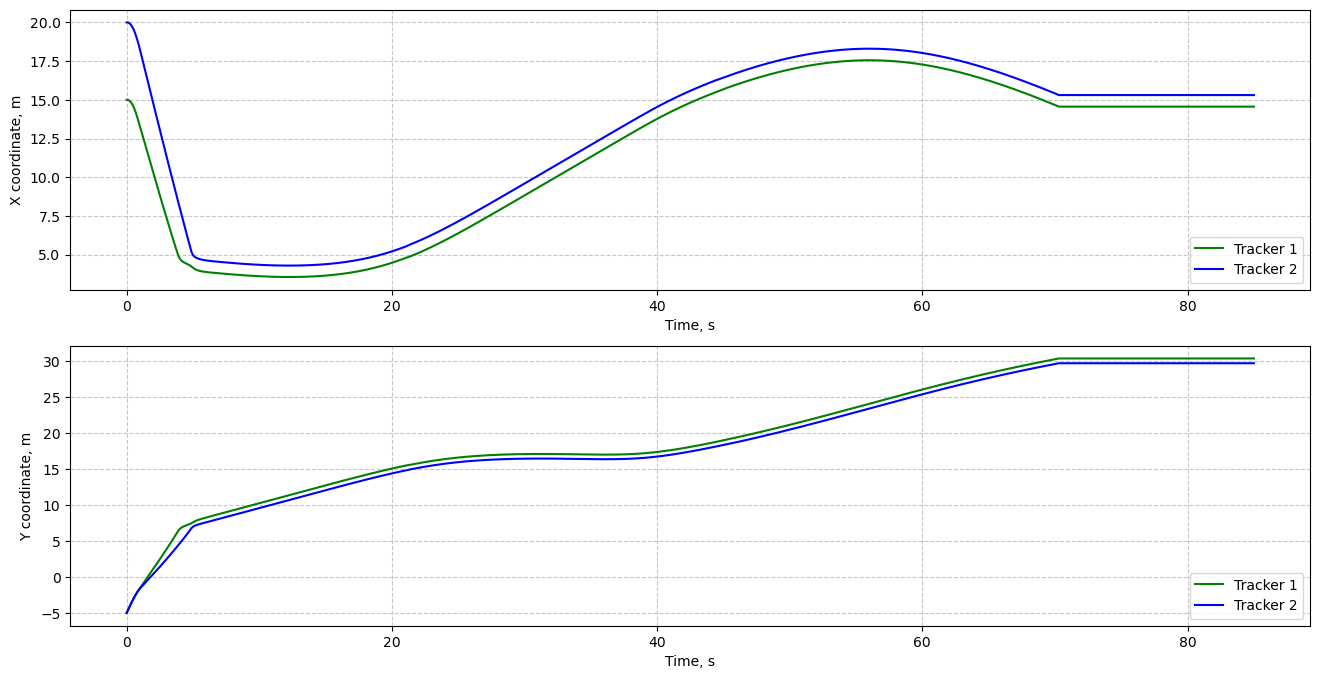

In [23]:
fig, (ax_coord_x, ax_coord_y) = plt.subplots(2, 1, figsize=(16, 8))

ax_coord_x.set_xlabel('Time, s')
ax_coord_x.set_ylabel('X coordinate, m')
ax_coord_x.grid(True, linestyle="--", alpha=0.7)

ax_coord_y.set_xlabel('Time, s')
ax_coord_y.set_ylabel('Y coordinate, m')
ax_coord_y.grid(True, linestyle="--", alpha=0.7)

# Get state storages
tracker1_states = tracker1.get_state_storage()
tracker2_states = tracker2.get_state_storage()

ax_coord_x.plot(storage_timeline, tracker1_states[0, :], '-', label='Tracker 1', color='green')
ax_coord_x.plot(storage_timeline, tracker2_states[0, :], '-', label='Tracker 2', color='blue')
ax_coord_x.legend(loc='lower right')

ax_coord_y.plot(storage_timeline, tracker1_states[1, :], '-', label='Tracker 1', color='green')
ax_coord_y.plot(storage_timeline, tracker2_states[1, :], '-', label='Tracker 2', color='blue')
ax_coord_y.legend(loc='lower right')
plt.show()

## Trackers control vector

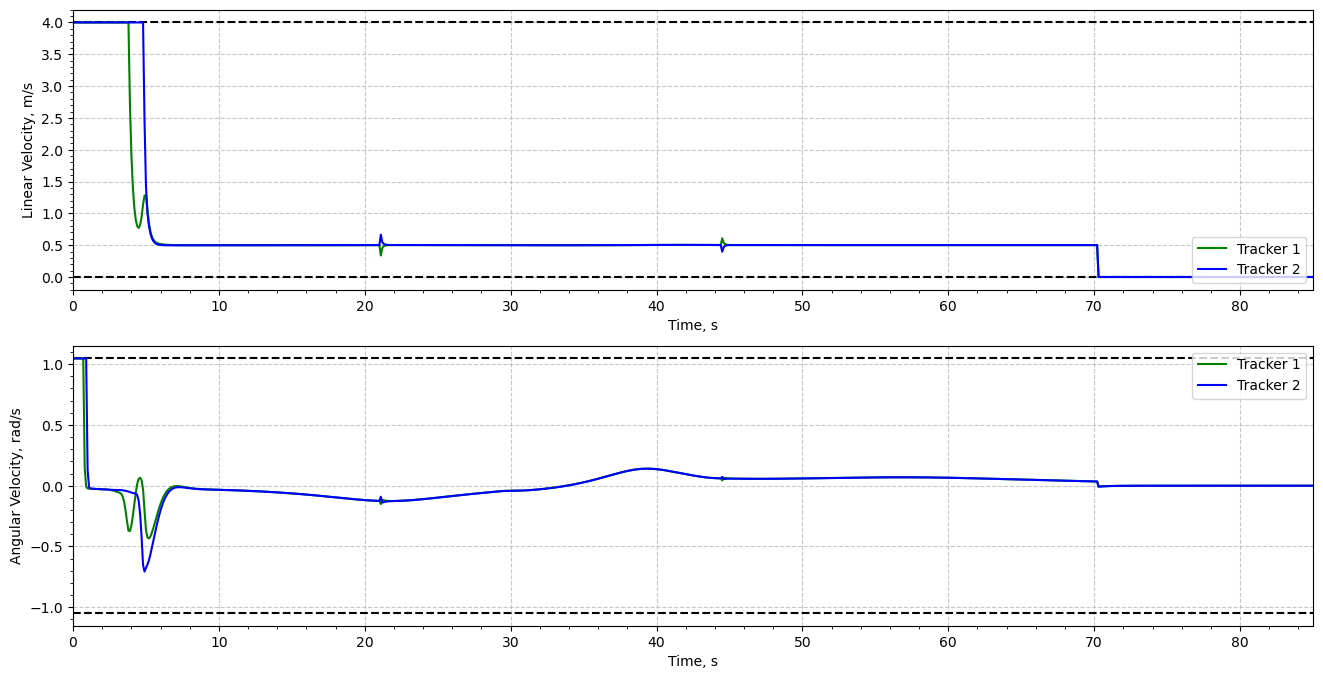

In [24]:
fig, (ax_linear, ax_angular) = plt.subplots(2, 1, figsize=(16, 8))

ax_linear.set_xlabel('Time, s')
ax_linear.set_ylabel('Linear Velocity, m/s')
ax_linear.grid(True, linestyle="--", alpha=0.7)
ax_linear.set_xlim(storage_timeline[0], storage_timeline[-1])
ax_linear.minorticks_on()

ax_angular.set_xlabel('Time, s')
ax_angular.set_ylabel('Angular Velocity, rad/s')
ax_angular.grid(True, linestyle="--", alpha=0.7)
ax_angular.set_xlim(storage_timeline[0], storage_timeline[-1])
ax_angular.minorticks_on()

# Get state storages
tracker1_controls = tracker1.get_control_storage()
tracker2_controls = tracker2.get_control_storage()

ax_linear.axhline(y = np.max(VLimitTracker), color = 'k', linestyle = '--')
ax_linear.axhline(y = np.min(VLimitTracker), color = 'k', linestyle = '--')

ax_linear.plot(storage_timeline, tracker1_controls[:, 0], '-', label='Tracker 1', color='green')
ax_linear.plot(storage_timeline, tracker2_controls[:, 0], '-', label='Tracker 2', color='blue')
ax_linear.legend(loc='lower right')

ax_angular.axhline(y = np.min(OmegaLimitTracker), color = 'k', linestyle = '--')
ax_angular.axhline(y = np.max(OmegaLimitTracker), color = 'k', linestyle = '--')

ax_angular.plot(storage_timeline, tracker1_controls[:, 1], '-', label='Tracker 1', color='green')
ax_angular.plot(storage_timeline, tracker2_controls[:, 1], '-', label='Tracker 2', color='blue')
ax_angular.legend(loc='upper right')
plt.show()

## Cumulative Solution Histogram for the Circulation Trajectory

851


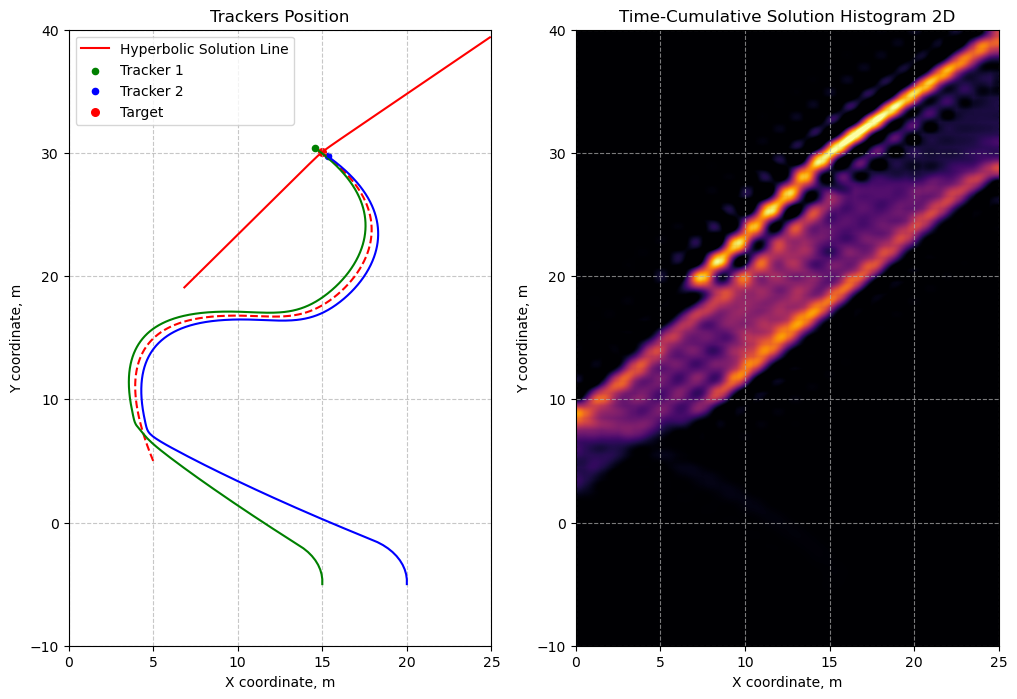

In [25]:
# Instance for plotting the histograms
histigram_range_x = (  0, 25)
histigram_range_y = (-10, 40)
tdoa_plot = TDoAPlot(histigram_range_x, histigram_range_y, True, -1)

# Get state storages
tracker1_states = tracker1.get_state_storage()
tracker2_states = tracker2.get_state_storage()

print(sim_steps)
for i in range(sim_steps):
    target_position = storage_target_states[0:2, i].flatten()
    tracker1_position = tracker1_states[0:2, i].flatten()
    tracker2_position = tracker2_states[0:2, i].flatten()
    
    tdoa_plot.add_solution(target_position, tracker1_position, tracker2_position)

tdoa_plot.calculate_histograms(0)
plt.show()

In [26]:
# Instance for plotting the histograms
histigram_range_x = (  0, 25)
histigram_range_y = (-10, 40)
tdoa_plot = TDoAPlot(histigram_range_x, histigram_range_y, True, -1)
tdoa_plot.close_plot()

# Get state storages
tracker1_states = tracker1.get_state_storage()
tracker2_states = tracker2.get_state_storage()

DesiredSteps = 300
factor = sim_steps / DesiredSteps

def animation_step(t: float):
    target_position = storage_target_states[0:2, int(factor * t)].flatten()
    tracker1_position = tracker1_states[0:2, int(factor * t)].flatten()
    tracker2_position = tracker2_states[0:2, int(factor * t)].flatten()
    return (target_position, tracker1_position, tracker2_position)

video_path = tdoa_plot.make_animation(file_path=Path(f'fig/cumulative trajectories case {CaseNumber}.mp4'),
                                      animation_step_fn=animation_step,
                                      steps=DesiredSteps, time_interval=150)
run_video(video_path)